# **0. Setup data**

In [ ]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Import dataset
df = pd.read_csv('/content/dataset.csv', encoding='latin-1')

<ipython-input-2-8ae0bb9827e8>:2: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/vietdata.csv', encoding='latin-1')


# **I. Understanding dataset**

In [ ]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541901 non-null  object 
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541887 non-null  object 
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(1), object(7)
memory usage: 33.1+ MB


((541909, 8), None)

 **Abnormal Finding:** It appears abnormal type of:
 1. Quantity and InvoiceNo which need to be in numeric type
 2. InvoiceDate needs to be in datetime

In [ ]:
df.head()

InvoiceNo StockCode                          Description Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER        6   
1    536365     71053                  WHITE METAL LANTERN        6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER        8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE        6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.        6   

      InvoiceDate UnitPrice  CustomerID         Country  
0  12/1/2010 8:26      2.55     17850.0  United Kingdom  
1  12/1/2010 8:26      3.39     17850.0  United Kingdom  
2  12/1/2010 8:26      2.75     17850.0  United Kingdom  
3  12/1/2010 8:26      3.39     17850.0  United Kingdom  
4  12/1/2010 8:26      3.39     17850.0  United Kingdom

In [ ]:
col = ['Description', 'InvoiceDate','Country']

for i, col in enumerate(col):
  unique_value = df[col].unique()
  print(f"Unique values in column '{col}': {unique_value}")

Unique values in column 'Description': ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
Unique values in column 'InvoiceDate': ['12/1/2010 8:26' '12/1/2010 8:28' '12/1/2010 8:34' ... '12/9/2011 12:31'
 '12/9/2011 12:49' '12/9/2011 12:50']
Unique values in column 'Country': ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [ ]:
#Convert to right format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['InvoiceNo'] = pd.to_numeric(df['InvoiceNo'], errors='coerce')

df['InvoiceDate'].agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

In [ ]:
col = ['Quantity','UnitPrice']

for i, col in enumerate(col):
  df[col] = pd.to_numeric(df[col], errors='coerce')
  min = df[col].min()
  max = df[col].max()
  print(f"Min value in column '{col}': {min}")
  print(f"Max value in column '{col}': {max}")

Min value in column 'Quantity': -80995.0
Max value in column 'Quantity': 80995.0
Min value in column 'UnitPrice': -11062.06
Max value in column 'UnitPrice': 38970.0


 **Abnormal Finding:** It appears abnormal values in negative, I've checked that:
 1. For Quantity, it accounts for **~1.9% of total rows < 5%** and **9.3% accountable in sum of Quantity**, meaning that it could be record as depth discount or return from customers or even human-error
 2. For UnitPrice, it accounts for **2 rows 'Adjust bad debt'** description - not impact to overall

**Understanding:** The dataset gives the order trasaction information of:
+ **Location:** lobal countries
+ **Type of goods:** Stationery and handmade categories
+ **Time:** From 	2010-12-01 to 	2011-12-09 (Almost a year)

# **II. Pre-processing data**

## **1. Cleaning**

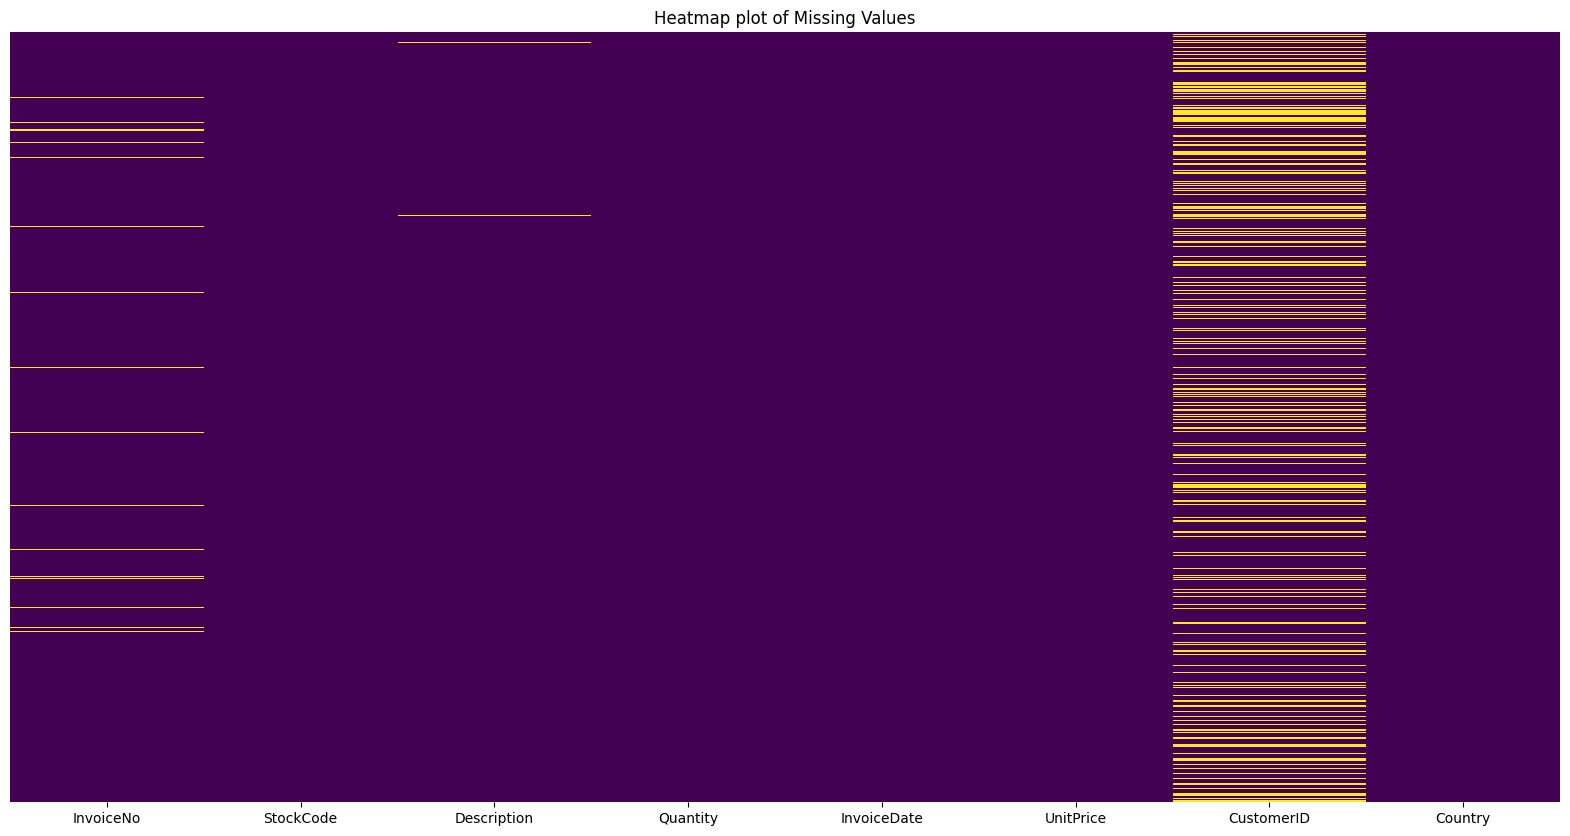

In [ ]:
# Check missing values in the df
plt.figure(figsize = (20, 10))
sns.heatmap(df.isnull(), cbar = False, cmap = 'viridis', yticklabels = False)
plt.title('Heatmap plot of Missing Values')
plt.show()

#The yellow in heatmap is the position of blank cell in dataset

The key missing in the data is a bit in InVoiceNo, Description (could be ignored) and **mostly from Customer ID**

In [ ]:
#Check for the % of null value in InvoiceNo
df['InvoiceNo'].isnull().sum() / df['InvoiceNo'].size

0.017144944999990773

The % of null values in InVoiceNo is **1.7% < 5%** meaning it won't impact much to the dataset if we exclude them.

In [ ]:
#Check for the % of null value in Customer ID
df['CustomerID'].isnull().sum() / df['CustomerID'].size

0.249266943342886

The % of null values in CustomerID is **25% > 5%** meaning it will impact to the dataset if we exclude them.

Moreover, I've checked that the null in each CustomerID has different InvoiceNo with its near non-null rows, so **we cannot match them by the same InvoiceNo**

=> Hence, we just only treat them as the **missing records of the Invoice**

## **2. Transforming Table**

In [ ]:
#Create needed columns for analysis
df['revenue'] = df['Quantity']*df['UnitPrice']
df['day'] = pd.to_datetime(df['InvoiceDate'].dt.strftime('%Y-%m-%d'))

df.head()

InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day  
0 2010-12-01  
1 2010-12-01  
2 2010-12-01  
3 2010-12-01  
4 2010-12-01

# **III. Analysis**

##**0. Concept Briefing**

The analysis follows for the below standard understanding of customer's transaction metrics:

**(1) Revenue** = No. Customers *(CustomerID)* x Spending by Customer

**(2) Spending by Customer** = No. Orders *(count distinct of InvoiceNo)* x Spending by Order

**(3) No. Orders** = Quantity x Orders per Quantity

**(4) Spending by Order** = Avg UnitPrice x No. Product

**(5) No. Product** = Avg Quantity per Product type x Type of Product *(Description)*


Based on the standard, the analysis will be flexibly approached to calculate more related metrics

## **1. Overview**

In [ ]:
data = df.copy()

#Split timeframe to year for checking long-term performance
data['month'] = data['day'].dt.month
data['monthly'] = data['day'].dt.to_period('M')

data.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day  month  monthly  
0 2010-12-01     12  2010-12  
1 2010-12-01     12  2010-12  
2 2010-12-01     12  2010-12  
3 2010-12-01     12  2010-12  
4 2010-12-01     12  2010-12

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Correlation of variables')

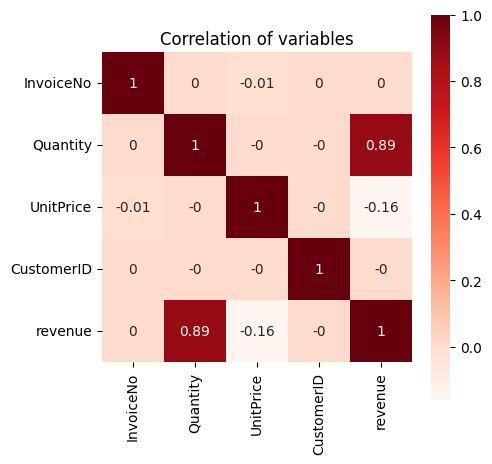

In [ ]:
# Corr Analysis
numerical_df = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr().round(2)
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix,annot=True, square=True, cmap='Reds')
plt.title('Correlation of variables')

Due to the corr map, besides common sense between revenue and quantity, the concern is about the **un-correlated relationship between unit price with quantity**

=> **Hypo:** Might impacts by different product types (Description) which will be dived into further

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


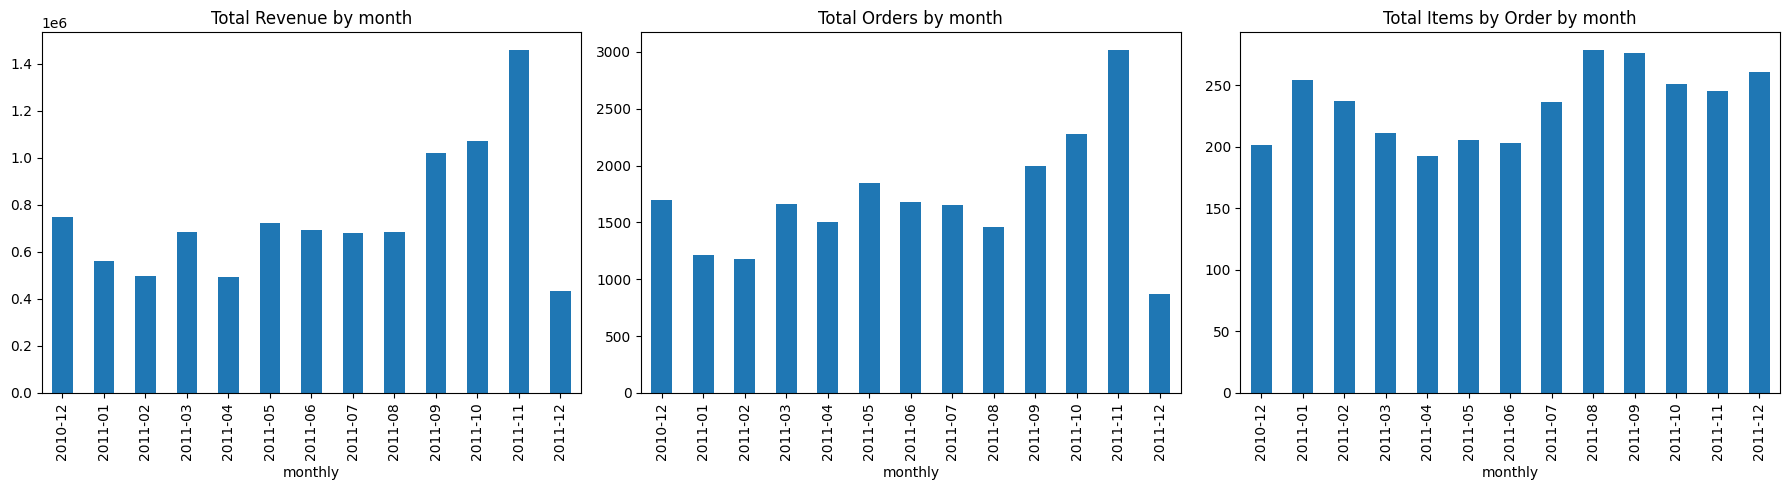

In [ ]:
#Calculate needed information

total_revenue = data.groupby('monthly')['revenue'].sum()
total_quantity = data.groupby('monthly')['Quantity'].sum()
total_orders = data.groupby('monthly')['InvoiceNo'].nunique() #Define 1 order equal to 1 InvoiceNo as transaction
totaL_items_by_order = total_quantity/total_orders

#Visualize
fig, axes = plt.subplots(1,3, figsize=(18,5))
ax = axes.flatten()

total_revenue.plot(kind = 'bar',rot = 90,ax=ax[0])
total_orders.plot(kind = 'bar',rot = 90,ax=ax[1])
totaL_items_by_order.plot(kind = 'bar',rot = 90,ax=ax[2])

ax[0].set_title('Total Revenue by month')
ax[1].set_title('Total Orders by month')
ax[2].set_title('Total Items by Order by month')

plt.tight_layout()
plt.show()

*Note:*  As the max timeframe is 2011-12-09 so the 2011-12 does not cover the full month so will be excluded when comparing vs other month

**Findings:**

**1. Seasonal Trend:** Observe the increasing in both revenue and quantity throughout the Quarter in year from the begining to the end

=> Regarding, **peak season of business comes from the Q4 in year** with highest revenue and quantity (demand), despite higher price showing that the customers has strong demand in this period


**2. Quarterly month trend:** Diving into each Quarter, observe the **highest performance coming from the last month of that Quarter** with all highest in revenue, quantity and price

=> These will be the often key focus for business to leverage for making impactful actions

**3. Spending:** The peak in seasonal trend mainly comes from the **uplift in total spending with more items at same price**

=> The key driver to uplift could be considered as **Pushing them buy more higher price units in one order transaction** to leverage their higher order-buying frequency

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


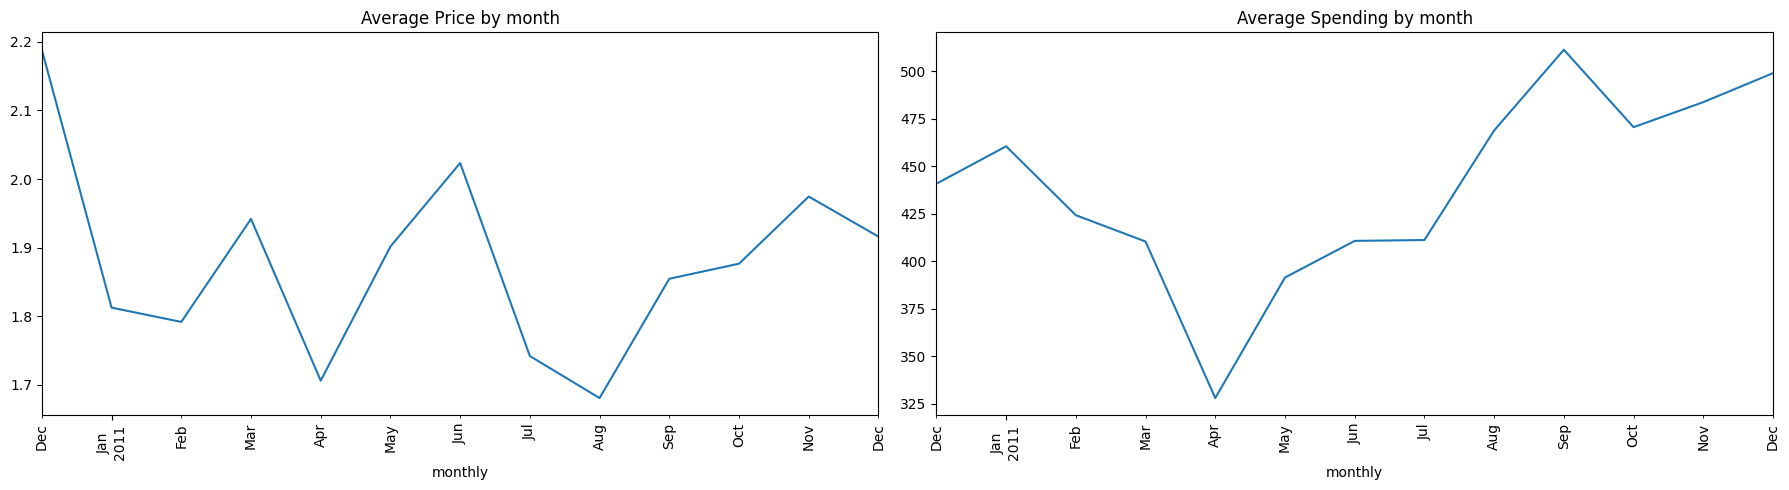

In [ ]:
#Calculate needed information
avg_price = total_revenue / total_quantity #avg price is calculated by total baseline of revenue and quantity to avoid the impact of standard error
avg_spending = total_revenue / total_orders

#Visualize
fig, axes = plt.subplots(1,2, figsize=(18,5))
ax = axes.flatten()

avg_price.plot(kind = 'line',rot = 90,ax=ax[0])
avg_spending.plot(kind = 'line',rot = 90,ax=ax[1])

ax[0].set_title('Average Price by month')
ax[1].set_title('Average Spending by month')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


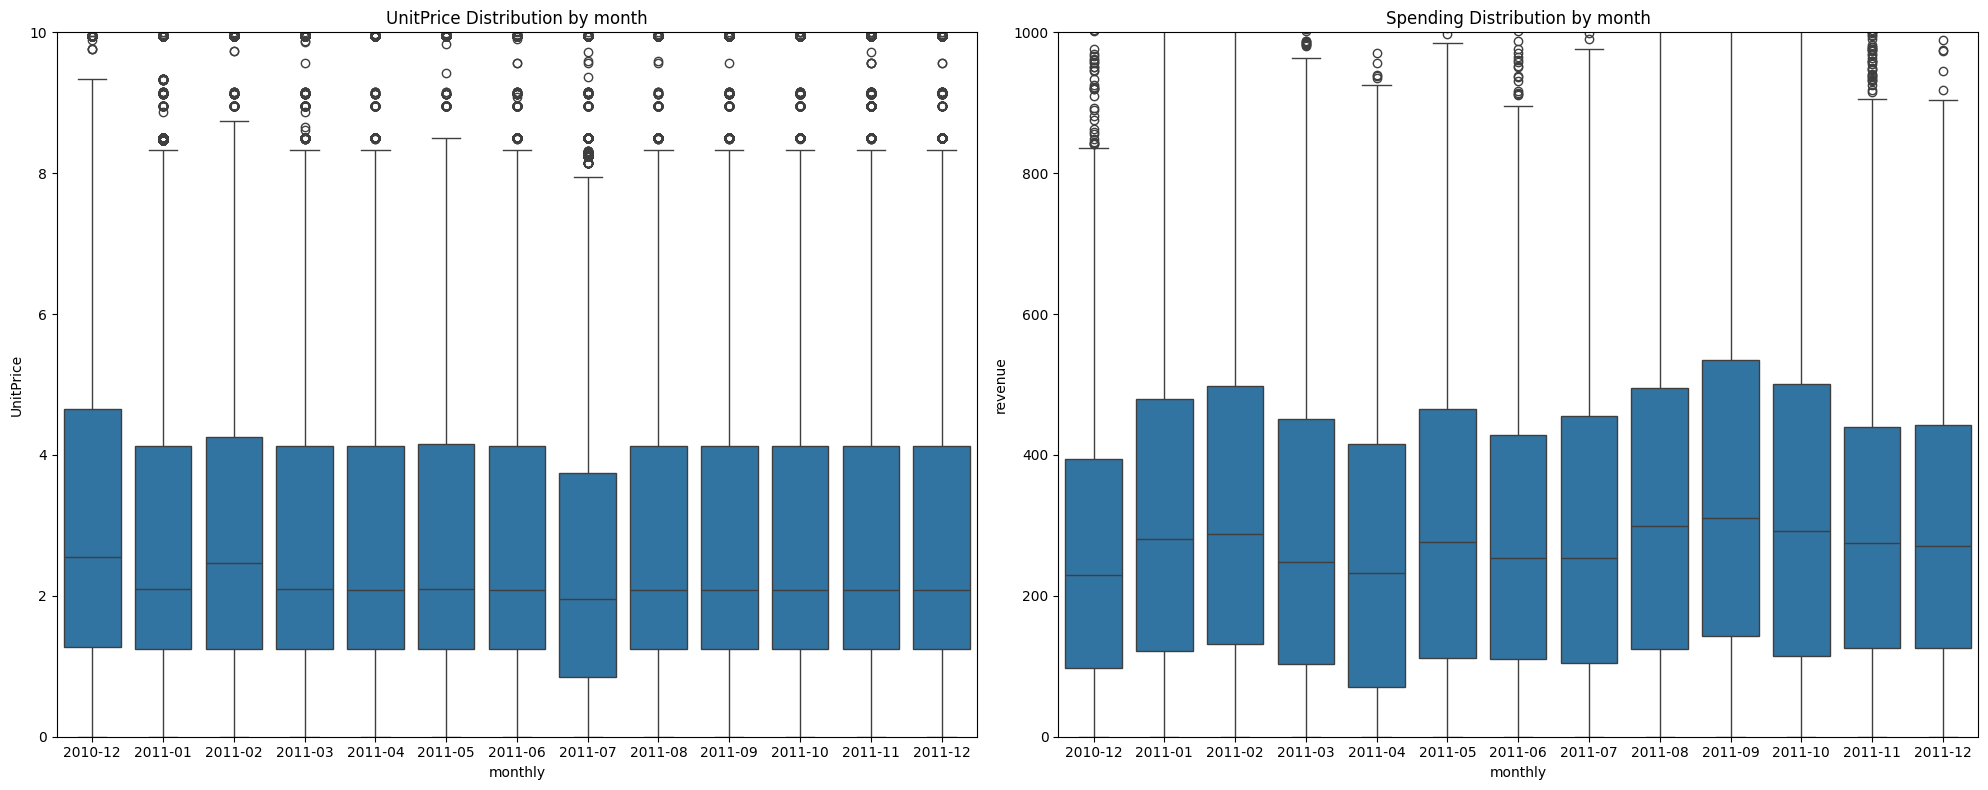

In [ ]:
#Regarding to the higher-paying price of seasonal, I dive more to see what's the pattern led to their increase demand payment by pricing distribution
fig, axes = plt.subplots(1,2, figsize=(20,8))
ax = axes.flatten()

#Chart 1
sns.boxplot(data = data, x = data['monthly'],y ='UnitPrice',ax =ax[0])
ax[0].set_ylim(0, 10)
ax[0].set_title('UnitPrice Distribution by month')

#Chart 2
revenue_by_order = data.groupby(['InvoiceNo', 'monthly'])['revenue'].sum().reset_index()

sns.boxplot(data = revenue_by_order, x = 'monthly', y ='revenue',ax =ax[1])
ax[1].set_ylim(0, 1000)
ax[1].set_title('Spending Distribution by month')

plt.tight_layout()
plt.show()

There are the interesting findings here:

**1.** The different in the above price/spending across months mostly **impacts by the outlier**
=> This means that **most group of users still maintain their spending** and **might appears "Big spender" customer group** which might be potential to analyze more besides.

**2.**Due to Chart 1, it still show the increase in paying demand of **December and July** which shows that
+ December customers pay more for higher price products
+ July customers pay more for lower price products

*Note: Further check: if I've the dataset with longer duration, I could validate these points by comparing YoY to see the movement of price/spending*

## **2. Customer Profile Analysis**: Who's the key customers of business ?

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-dbd68bd61679>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax[1].text(chart_2['orders_by_country'][i], chart_2['items_by_order'][i], country))
<ipython-input-25-dbd68bd61679>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts_2.

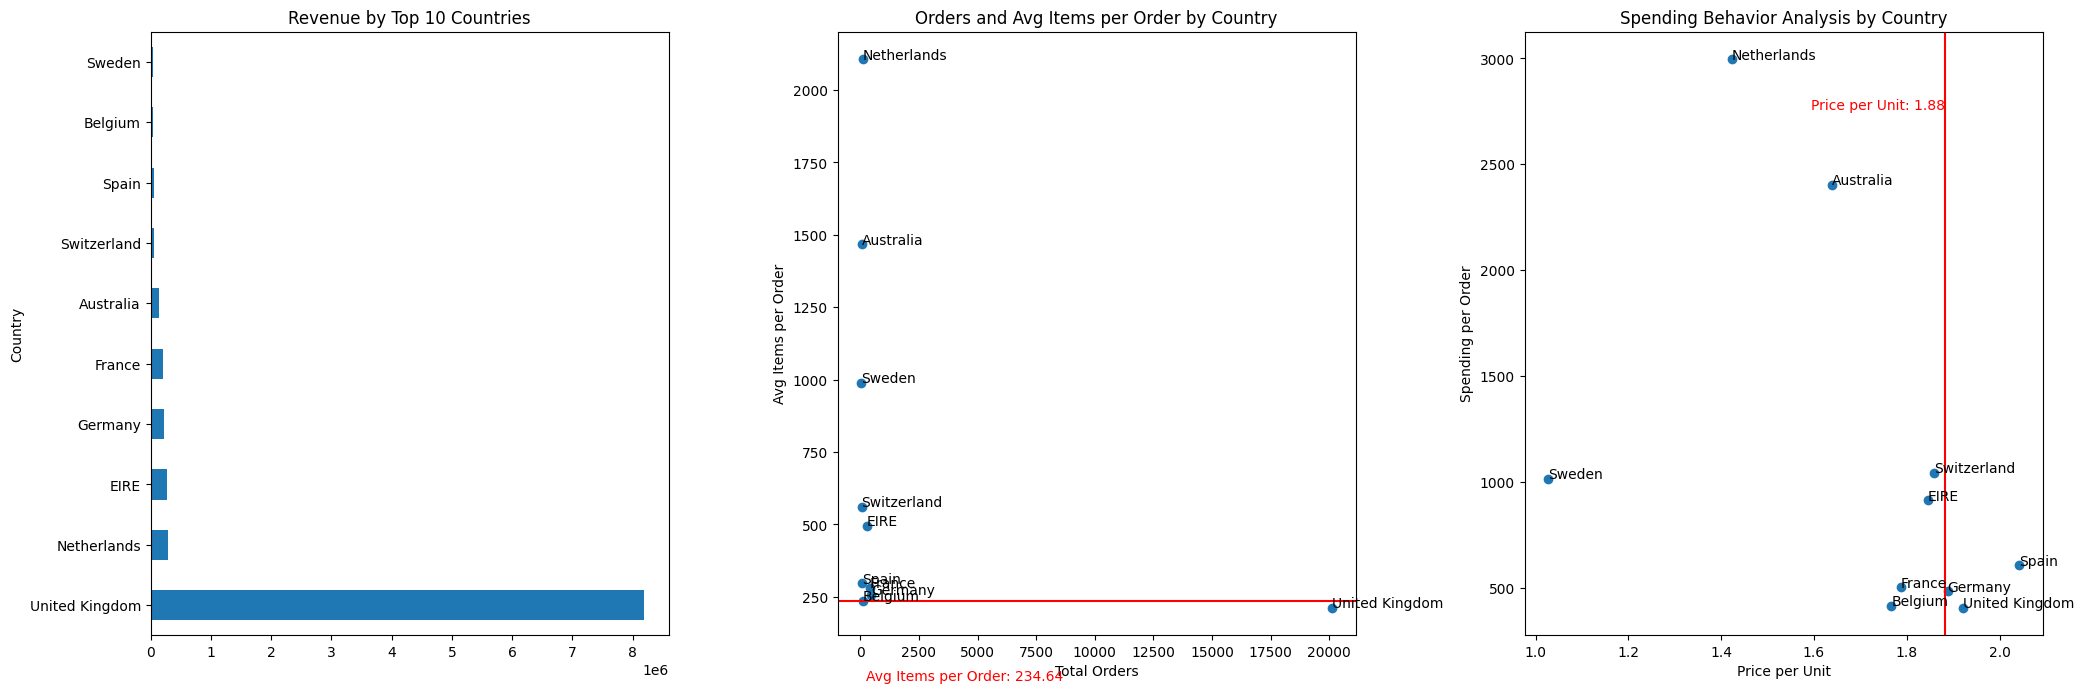

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
ax = axes.flatten()

#Visualize 1: Revenue by TOP 10 country
revenue_by_country = df.groupby('Country')['revenue'].sum().sort_values(ascending = False).head(10)
revenue_by_country.plot(kind = 'barh', ax = ax[0])
ax[0].set_title('Revenue by Top 10 Countries')

#Visualize 2: Orders & Items by Order by TOP 20 country
chart_2 = data[data['Country'].isin(revenue_by_country.index)] \
               .groupby('Country') \
               .agg( orders_by_country =('InvoiceNo', 'nunique')
                     , items_by_order =pd.NamedAgg(column='Quantity', aggfunc=lambda x: x.sum() / data.loc[x.index, 'InvoiceNo'].nunique())
                   )

ax[1].scatter(chart_2['orders_by_country'], chart_2['items_by_order'])
ax[1].set_title('Orders and Avg Items per Order by Country')
ax[1].set_xlabel('Total Orders')
ax[1].set_ylabel('Avg Items per Order')

# Label the dots
texts = []

for i, country in enumerate(chart_2.index):
    texts.append(ax[1].text(chart_2['orders_by_country'][i], chart_2['items_by_order'][i], country))

# Add vertical lines for avg price of total to compare
avg_items_per_order = data['Quantity'].sum()/data['InvoiceNo'].nunique()
ax[1].axhline(avg_items_per_order, color='r', linestyle='-', label='Avg Items per Order')
ax[1].text(avg_items_per_order, plt.ylim()[1] * 0.9, f'Avg Items per Order: {avg_items_per_order:.2f}', color='r', ha='left', va='top')

#Visualize 3: Spending Behavior by TOP 20 country
chart_3 = data[data['Country'].isin(revenue_by_country.index)] \
               .groupby('Country') \
               .agg( price_per_unit =pd.NamedAgg(column='revenue', aggfunc=lambda x: x.sum() / data.loc[x.index, 'Quantity'].sum())
                     , spending_per_order =pd.NamedAgg(column='revenue', aggfunc=lambda x: x.sum() / data.loc[x.index, 'InvoiceNo'].nunique())
                   )

ax[2].scatter(chart_3['price_per_unit'], chart_3['spending_per_order'])
ax[2].set_title('Spending Behavior Analysis by Country')
ax[2].set_xlabel('Price per Unit')
ax[2].set_ylabel('Spending per Order')

# Label the dots for Price per Unit
texts_2 = []

for i, country in enumerate(chart_3.index):
    texts_2.append(ax[2].text(chart_3['price_per_unit'][i], chart_3['spending_per_order'][i], country))

# Add vertical lines for avg price of total to compare
avg_price_per_unit = data['revenue'].sum()/data['Quantity'].sum()
ax[2].axvline(avg_price_per_unit, color='r', linestyle='-', label='Price per Unit')
ax[2].text(avg_price_per_unit, ax[2].get_ylim()[1] * 0.9, f'Price per Unit: {avg_price_per_unit:.2f}', color='r', ha='right', va='top')

plt.tight_layout()
plt.show()

## **3. Product Performance Analysis:** What's the key products offering to meet their demand ?


**Findings:**

**1. From bar chart 1:** Identify the most importance customer group is from European countries

-> From here, we could understand about the demand of our top customer groups by:


**2.From scatter chart 2 & 3:** It shows the difference buying behavior between them:
+ **For UK (1st important):** Buy many orders (times) with less items by one orders at upper-mainstream price

*Explain:* Buy many orders with normal avg quantity of items per order, and buy products with price at normal baseline that leads to their lower spending per order

+ **For Netherlands (2nd important):** Buy many economy products

*Explain:* Both buy  orders with items at higher level than most of others, but buy at the economy price (mostly cheaper than others)

+ **For Germany & EIRE (3rd & 4th important):** Buy many items in one order at mainstream price

*Explain:* Buy many items in one order at lower orders level than others, with the demand at mainstream price products


---

**Conclude for direction:**
By observing the key different characteristics in those countries, **we could group them based on that** whether the business decides to **make country-focused strategies** in the future by 4 groups:
+ **Frequent Shoppers:** Place frequent orders with fewer items at mainstream prices (example as UK).
+ **Budget Maximizers:** Buy many items per order, focusing on economy-priced products (example as Netherlands)
+ **Bulk Buyers:** Place fewer orders but purchase many items at mainstream prices (example as Germany, EIRE)
+ **Diverse Buyers:** Exhibit varied shopping behavior with fluctuating quantity and price preferences (example as other countries)




/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


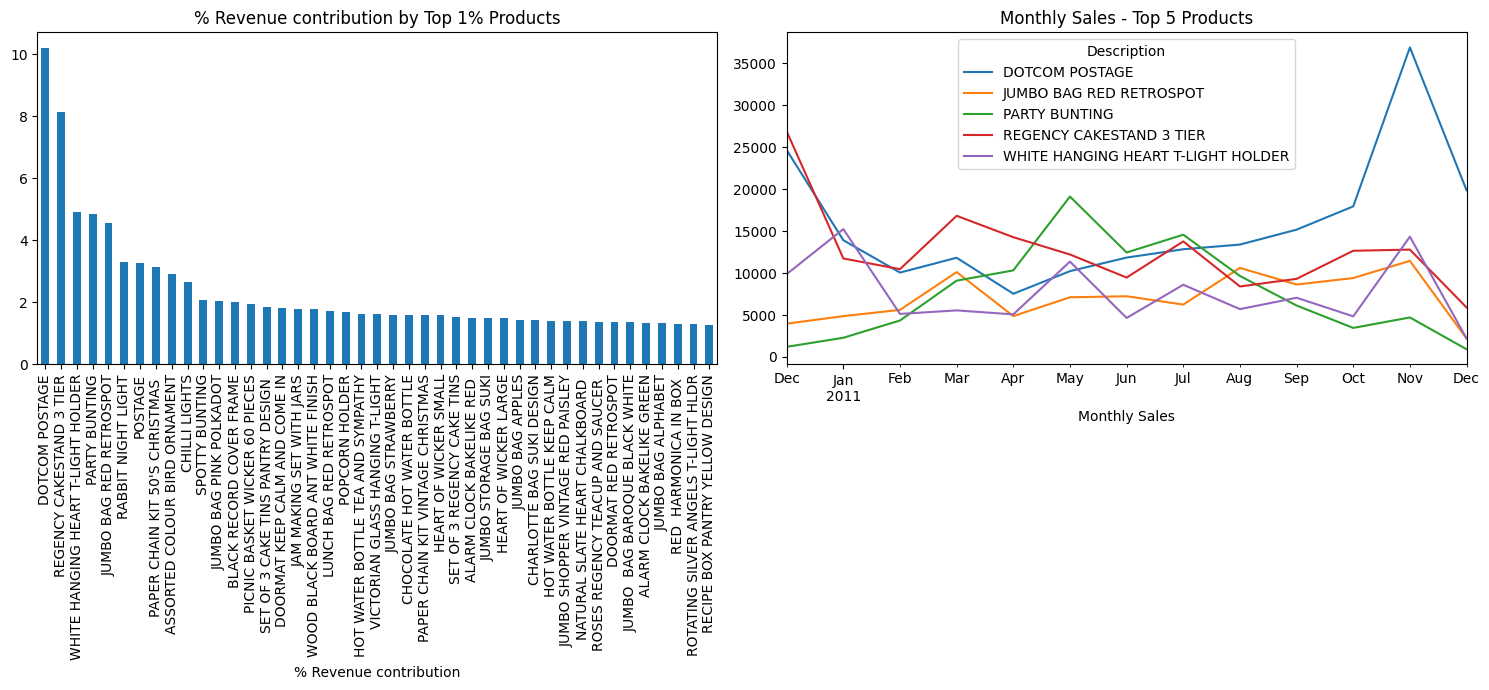

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax = axes.flatten()

# Filter to the top 1% products by revenue contribution
top_product = data.groupby('Description')['revenue'].sum().sort_values(ascending=False)
threshold = top_product.quantile(0.99)

# Filter Top 1% products
top_1pct_product = top_product[top_product >= threshold]

# Chart 1. % Revenue contribution for each product
total_revenue = top_1pct_product.sum()
top_product_percentage = (top_1pct_product / total_revenue) * 100

top_product_percentage.plot(kind='bar', rot = 90, ax=ax[0])
ax[0].set_title('% Revenue contribution by Top 1% Products')
ax[0].set_xlabel('% Revenue contribution')

# Chart 2. UnitPrice by each product
top_5_product = data.groupby('Description')['revenue'].sum().sort_values(ascending=False).head(5)

monthly_sales_by_product = data[data['Description'].isin(top_5_product.index)] \
                                                   .groupby(['monthly', 'Description'])['revenue'].sum() \
                                                   .reset_index()

#Pivot to draw line chart
monthly_sales_pivot = monthly_sales_by_product.pivot(index='monthly', columns='Description', values='revenue')

monthly_sales_pivot.plot(kind='line', ax=ax[1])
ax[1].set_title('Monthly Sales - Top 5 Products')
ax[1].set_xlabel('Monthly Sales')

plt.tight_layout()
plt.show()

**Findings:**

**Chart 1:** Observe that the revnenue contribution across products show a small GAP, meaning that the **business provides dynamic types of product** that match with varios of demands

=> The key to drive the impacts mostly I propose will begin with the Customer sectors to identify the key winning points, as across products do not show obvious difference

=> Moreover, This could be considered as a advantage competitive as positioning with comprehensive product portfolio vs other competitors

Note: Due to the varios product types, it's un-needed to walk through/show all of them

**Chart 2.** For top 5-Cont products, observe the mostly same trend aligning with total business for the peak time in the end of year, only Party Bunting shows the peak season in the middle of the year

=> By leveraging each peak demand times of product, business could create the product-driven strategy by each seasons to win the customers

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-27-501e985b1833>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts_top_10_product_spending.append(ax[0].text(top_10_product_spending['price_per_unit'][i], top_10_product_spending['spending_per_order'][i], product))
<ipython-input-27-501e985b1833>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

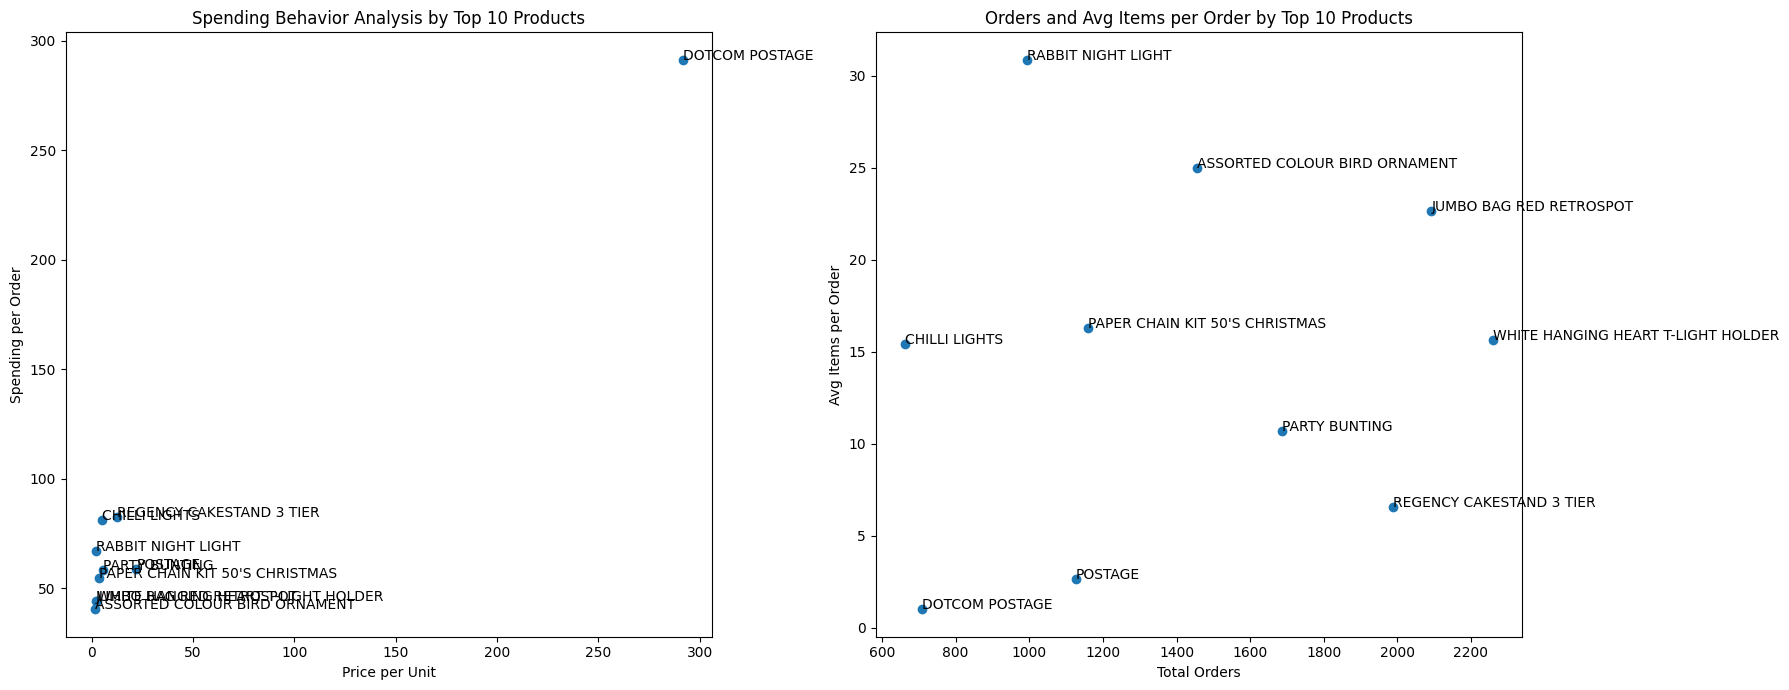

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
ax = axes.flatten()

top_10_product = data.groupby('Description')['revenue'].sum().sort_values(ascending=False).head(10)

#Visualize 1: Spending Behavior by TOP 10 products
top_10_product_spending = data[data['Description'].isin(top_10_product.index)] \
                                                  .groupby('Description') \
                                                  .agg( price_per_unit =pd.NamedAgg(column='revenue', aggfunc=lambda x: x.sum() / data.loc[x.index, 'Quantity'].sum())
                                                        , spending_per_order =pd.NamedAgg(column='revenue', aggfunc=lambda x: x.sum() / data.loc[x.index, 'InvoiceNo'].nunique())
                                                      )

ax[0].scatter(top_10_product_spending['price_per_unit'], top_10_product_spending['spending_per_order'])
ax[0].set_title('Spending Behavior Analysis by Top 10 Products')
ax[0].set_xlabel('Price per Unit')
ax[0].set_ylabel('Spending per Order')

# Label the dots
texts_top_10_product_spending = []

for i, product in enumerate(top_10_product_spending.index):
    texts_top_10_product_spending.append(ax[0].text(top_10_product_spending['price_per_unit'][i], top_10_product_spending['spending_per_order'][i], product))

#Visualize 2: Orders & Items by Order by TOP 10 products
top_10_product_items = data[data['Description'].isin(top_10_product.index)] \
                                                  .groupby('Description') \
                                                  .agg( orders_by_top_10_product =('InvoiceNo', 'nunique')
                                                        , items_by_order =pd.NamedAgg(column='Quantity', aggfunc=lambda x: x.sum() / data.loc[x.index, 'InvoiceNo'].nunique())
                                                      )

ax[1].scatter(top_10_product_items['orders_by_top_10_product'], top_10_product_items['items_by_order'])
ax[1].set_title('Orders and Avg Items per Order by Top 10 Products')
ax[1].set_xlabel('Total Orders')
ax[1].set_ylabel('Avg Items per Order')

# Label the dots
texts_top_10_product_items = []

for i, product in enumerate(top_10_product_items.index):
    texts_top_10_product_items.append(ax[1].text(top_10_product_items['orders_by_top_10_product'][i], top_10_product_items['items_by_order'][i], product))

plt.tight_layout()
plt.show()

Regarding to the above charts showing the **position of products and the demand sides**, we see that:

+ **Across top-performing products:** The key driver of them is mainly by the highere price and the Order Quantity

=> Customers buy them as mainstream to high price products with single or not much items in one order

=> This pattern can be treated as the key for business to drive through two factors: (i) Order Quantity as Frequency and (ii) Price if want to uplift these top performer


+ **Example for Dotcom Postage (1st important):** Premium product as value-purchase driver

=> Explain: The product driver of business is contributed by much higher price than others, as customers buy it by single unit and order

**Highlight to explain:** This could be the reason why the above correlation analysis show the weak relationship between UnitPrice and Quantity because they buy single Orders, instead of increasing in Items per Order

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


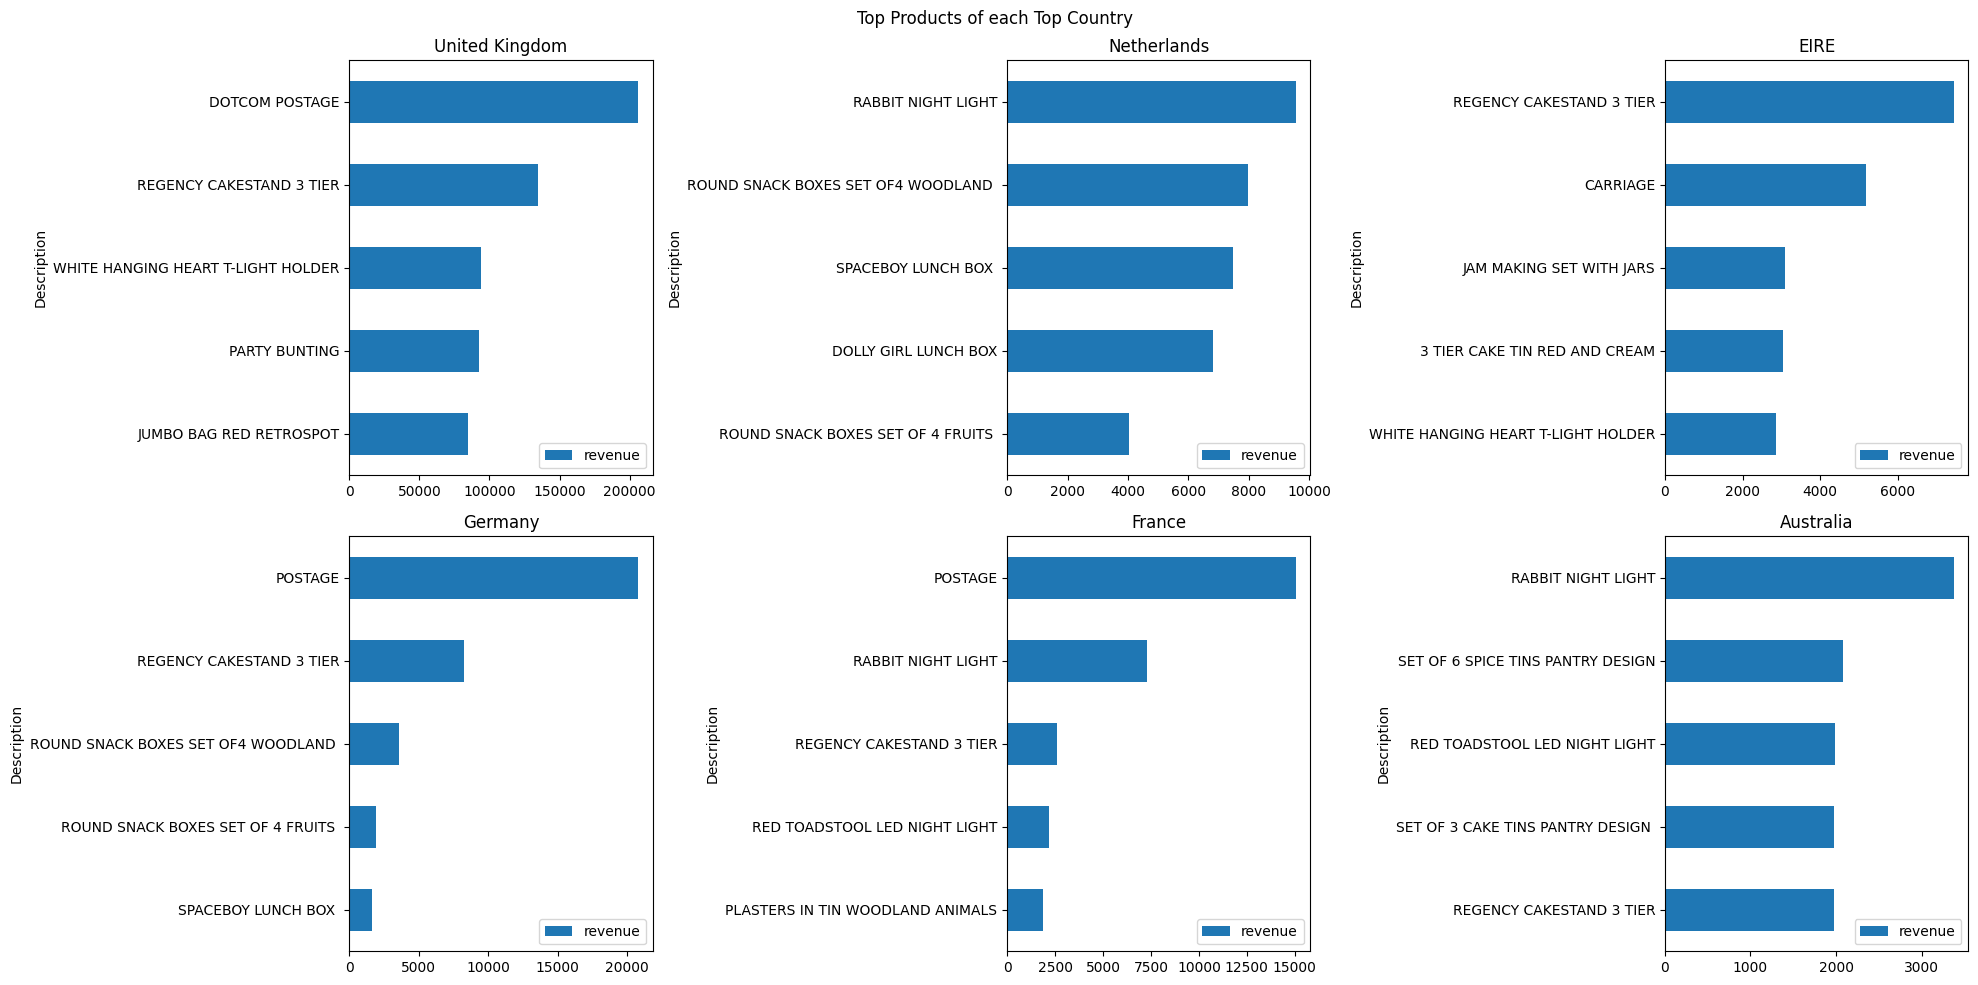

In [ ]:
#List of top 5 country by revenue
top_country = ['United Kingdom', 'Netherlands', 'EIRE', 'Germany', 'France','Australia']

fig, axes = plt.subplots(2,3, figsize=(20,10))
axes = axes.flatten()

for i, country in enumerate(top_country):
  rev_by_country = data[data['Country'] == country].groupby('Description').agg(revenue = ('revenue','sum')).sort_values(by = 'revenue',ascending = False).head(5)
  rev_by_country = rev_by_country.reset_index()
  rev_by_country.plot(kind='barh',x='Description',y='revenue', ax=axes[i], title = country)
  axes[i].invert_yaxis()

fig.suptitle('Top Products of each Top Country')
plt.tight_layout()
plt.show()

**Findings:**

Thanks to highest contribution, the UK becomes th key driver for across top products of the business

Besides it, we see for the others, it shows the dynamic products between them which could be potentially analyzed further to understand what's their customized needs

In [ ]:
# Calculate total revenue by country
total_rev_by_country = data.groupby('Country')['revenue'].sum().reset_index()
total_rev_by_country = total_rev_by_country.rename(columns={'revenue': 'total_revenue'})
total_rev_by_country = total_rev_by_country.set_index('Country')

all_rev_by_country = []

for i, country in enumerate(top_country):
    rev_by_country = data[data['Country'] == country].groupby('Description').agg(revenue=('revenue', 'sum')).sort_values(by='revenue', ascending=False).head(5)
    rev_by_country = rev_by_country.reset_index()
    rev_by_country['percentage'] = ((rev_by_country['revenue'] / total_rev_by_country.loc[country, 'total_revenue']) * 100).round(1)
    rev_by_country['Country'] = country
    all_rev_by_country.append(rev_by_country)

# Concatenate all DataFrames in the list
all_rev_by_country_df = pd.concat(all_rev_by_country)

all_rev_by_country_pv = pd.pivot_table(all_rev_by_country_df
                                      , values='percentage'
                                      , index='Description'
                                      , columns='Country'
                                      )

all_rev_by_country_pv

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Country                              Australia  EIRE  France  Germany  \
Description                                                             
3 TIER CAKE TIN RED AND CREAM              NaN   1.2     NaN      NaN   
CARRIAGE                                   NaN   2.0     NaN      NaN   
DOLLY GIRL LUNCH BOX                       NaN   NaN     NaN      NaN   
DOTCOM POSTAGE                             NaN   NaN     NaN      NaN   
JAM MAKING SET WITH JARS                   NaN   1.2     NaN      NaN   
JUMBO BAG RED RETROSPOT                    NaN   NaN     NaN      NaN   
PARTY BUNTING                              NaN   NaN     NaN      NaN   
PLASTERS IN TIN WOODLAND ANIMALS           NaN   NaN     0.9      NaN   
POSTAGE                                    NaN   NaN     7.6      9.4   
RABBIT NIGHT LIGHT                         2.5   NaN     3.7      NaN   
RED TOADSTOOL LED NIGHT LIGHT              1.4   NaN     1.1      NaN   
REGENCY CAKESTAND 3 TIER                   1.4   2.8     1.3      3.7   
ROUND SNACK BOXES SET OF 4 FRUITS          NaN   NaN     NaN      0.9   
ROUND SNACK BOXES SET OF4 WOODLAND         NaN   NaN     NaN      1.6   
SET OF 3 CAKE TINS PANTRY DESIGN           1.4   NaN     NaN      NaN   
SET OF 6 SPICE TINS PANTRY DESIGN          1.5   NaN     NaN      NaN   
SPACEBOY LUNCH BOX                         NaN   NaN     NaN      0.7   
WHITE HANGING HEART T-LIGHT HOLDER         NaN   1.1     NaN      NaN   

Country                              Netherlands  United Kingdom  
Description                                                       
3 TIER CAKE TIN RED AND CREAM                NaN             NaN  
CARRIAGE                                     NaN             NaN  
DOLLY GIRL LUNCH BOX                         2.4             NaN  
DOTCOM POSTAGE                               NaN             2.5  
JAM MAKING SET WITH JARS                     NaN             NaN  
JUMBO BAG RED RETROSPOT                      NaN             1.0  
PARTY BUNTING                                NaN             1.1  
PLASTERS IN TIN WOODLAND ANIMALS             NaN             NaN  
POSTAGE                                      NaN             NaN  
RABBIT NIGHT LIGHT                           3.4             NaN  
RED TOADSTOOL LED NIGHT LIGHT                NaN             NaN  
REGENCY CAKESTAND 3 TIER                     NaN             1.6  
ROUND SNACK BOXES SET OF 4 FRUITS            1.4             NaN  
ROUND SNACK BOXES SET OF4 WOODLAND           2.8             NaN  
SET OF 3 CAKE TINS PANTRY DESIGN             NaN             NaN  
SET OF 6 SPICE TINS PANTRY DESIGN            NaN             NaN  
SPACEBOY LUNCH BOX                           2.6             NaN  
WHITE HANGING HEART T-LIGHT HOLDER           NaN             1.1

**As we could see that, there are different dynamic in products between Top Countries.**

Example: The top Product as DOTCOM POSTAGE is the key and only contribution to the UK country, but only accounts for 3.4% revenue contribution

=> Hence, it's **easier to take the product-driven focus** if the business plans to target to specific group of countries based on their demands

# **IV. Strategy/Recommendations for Top 10% Customers and Churn Improvement**

Following up the key above finding, we dive into the persona of Top 10% to understand

## **1. Top 10% Customers**

In [ ]:
revenue_by_customer = data.groupby('CustomerID')['revenue'].sum().sort_values(ascending = False)
threshold = revenue_by_customer.quantile(0.9)

# Filter Top 10% customers
top_10_pct_customers = revenue_by_customer[revenue_by_customer >= threshold]

top_10_customer_df = data[data['CustomerID'].isin(top_10_pct_customers.index)]

top_10_customer_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day  month  monthly  
0 2010-12-01     12  2010-12  
1 2010-12-01     12  2010-12  
2 2010-12-01     12  2010-12  
3 2010-12-01     12  2010-12  
4 2010-12-01     12  2010-12

In [ ]:
#Calculate the overview of top 10% information in total
no_of_customers = top_10_customer_df['CustomerID'].nunique()
revenue_of_customers = top_10_customer_df['revenue'].sum()
orders_of_customers = top_10_customer_df['InvoiceNo'].nunique()
quantity_of_customers = top_10_customer_df['Quantity'].sum()

# Calculate contribution in total business
pct_no_of_customers = round(no_of_customers*100/data['CustomerID'].nunique(),1)
pct_revenue_of_customers= round(revenue_of_customers*100/data['revenue'].sum(),1)
pct_orders_of_customers = round(orders_of_customers*100/data['InvoiceNo'].nunique(),1)
pct_quantity_of_customers = round(quantity_of_customers*100/data['Quantity'].sum(),1)

overview_top10pct_df = pd.DataFrame({
                                    'Metric': ['No. of Customers', 'Revenue', 'Orders', 'Quantity'],
                                    'Absolute': [no_of_customers, revenue_of_customers, orders_of_customers, quantity_of_customers],
                                    'Percentage': [pct_no_of_customers, pct_revenue_of_customers, pct_orders_of_customers, pct_quantity_of_customers]
                                   })

print(overview_top10pct_df)

             Metric    Absolute  Percentage
0  No. of Customers      438.00        10.0
1           Revenue  4984002.38        51.1
2            Orders     7249.00        32.9
3          Quantity  2857294.00        55.2


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Findings:**

Overview for top 10% customers show that:
+ **They contribute high value for business**, accountable for 10% in small size but handle for over 50% in Revenue and Quantity

=> It highlights the confirmation that these 10% top customers are really important for business to take care


In [ ]:
#Know their persona

#By Country

no_of_customers_by_country = top_10_customer_df.groupby('Country')['CustomerID'].nunique()
revenue_of_customers_by_country = top_10_customer_df.groupby('Country')['revenue'].sum()
orders_of_customers_by_country = top_10_customer_df.groupby('Country')['InvoiceNo'].nunique()
quantity_of_customers_by_country = top_10_customer_df.groupby('Country')['Quantity'].sum()

#Calculate the proportion
pct_no_of_customers_by_country = round(no_of_customers_by_country*100/no_of_customers,1)
pct_revenue_of_customers_by_country = round(revenue_of_customers_by_country*100/revenue_of_customers,1)
pct_orders_of_customers_by_country = round(orders_of_customers_by_country*100/orders_of_customers,1)
pct_quantity_of_customers_by_country = round(quantity_of_customers_by_country*100/quantity_of_customers,1)

#Concat by index Country
concat_top_10 = pd.concat([no_of_customers_by_country
                           ,pct_no_of_customers_by_country
                           ,revenue_of_customers_by_country
                           ,pct_revenue_of_customers_by_country
                           ,orders_of_customers_by_country
                           ,pct_orders_of_customers_by_country
                           ,quantity_of_customers_by_country
                           ,pct_quantity_of_customers_by_country
                          ], axis=1)

#Rename header
concat_top_10.columns = ['No. of Customers', '% No.Customers', 'Revenue', '% Revenue', 'Orders', '% No.Orders', 'Quantity', '% No.Quantity']

concat_top_10_sorted = concat_top_10.sort_values(by='% Revenue', ascending=False)

concat_top_10_sorted

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


No. of Customers  % No.Customers     Revenue  % Revenue  \
Country                                                                    
United Kingdom                359            82.0  3792138.12       76.1   
Netherlands                     1             0.2   279489.02        5.6   
EIRE                            3             0.7   250285.22        5.0   
Germany                        21             4.8   145729.81        2.9   
France                         18             4.1   136143.77        2.7   
Australia                       2             0.5   129169.06        2.6   
Spain                           7             1.6    41491.07        0.8   
Switzerland                     5             1.1    34489.62        0.7   
Japan                           2             0.5    28001.05        0.6   
Norway                          4             0.9    27807.43        0.6   
Sweden                          1             0.2    30300.82        0.6   
Finland                         2             0.5    12741.08        0.3   
Belgium                         4             0.9    13337.15        0.3   
Denmark                         2             0.5    11142.31        0.2   
Cyprus                          2             0.5     9514.02        0.2   
Channel Islands                 1             0.2     8117.42        0.2   
Portugal                        2             0.5    11217.33        0.2   
Singapore                       1             0.2     9120.39        0.2   
Iceland                         1             0.2     4310.00        0.1   
Poland                          1             0.2     3868.70        0.1   
Israel                          1             0.2     4873.81        0.1   
Austria                         2             0.5      715.18        0.0   

                 Orders  % No.Orders   Quantity  % No.Quantity  
Country                                                         
United Kingdom     6215         85.7  2154428.0           75.4  
Netherlands          74          1.0   196719.0            6.9  
EIRE                260          3.6   136329.0            4.8  
Germany             264          3.6    73023.0            2.6  
France              197          2.7    73135.0            2.6  
Australia            34          0.5    79635.0            2.8  
Spain                42          0.6    18586.0            0.7  
Switzerland          14          0.2    19696.0            0.7  
Japan                 9          0.1    16506.0            0.6  
Norway               18          0.2    16289.0            0.6  
Sweden               15          0.2    32324.0            1.1  
Finland              18          0.2     4705.0            0.2  
Belgium              24          0.3     5512.0            0.2  
Denmark               5          0.1     3414.0            0.1  
Cyprus                7          0.1     3914.0            0.1  
Channel Islands       8          0.1     4083.0            0.1  
Portugal             20          0.3     6031.0            0.2  
Singapore             7          0.1     5234.0            0.2  
Iceland               7          0.1     2458.0            0.1  
Poland                8          0.1     1996.0            0.1  
Israel                1          0.0     3028.0            0.1  
Austria               2          0.0      249.0            0.0

**Findings:**

By calculate the importance by each metrics of the Country customers, it shows that:

+ **Mostly contribute from UK**, followed by the number of customers in Germany and France

+ The remaining is "Big Spender" with less in customer quantity

**=> Direction:** Due to the common sense and above analysis, we see that between countries have different demand of product types. => So to maximize the output and ROI to win, the **strategy should be implemented by Country-focus driver**

Additionally, to diving more we will dive into their spending distribution and unit price of products they buy

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


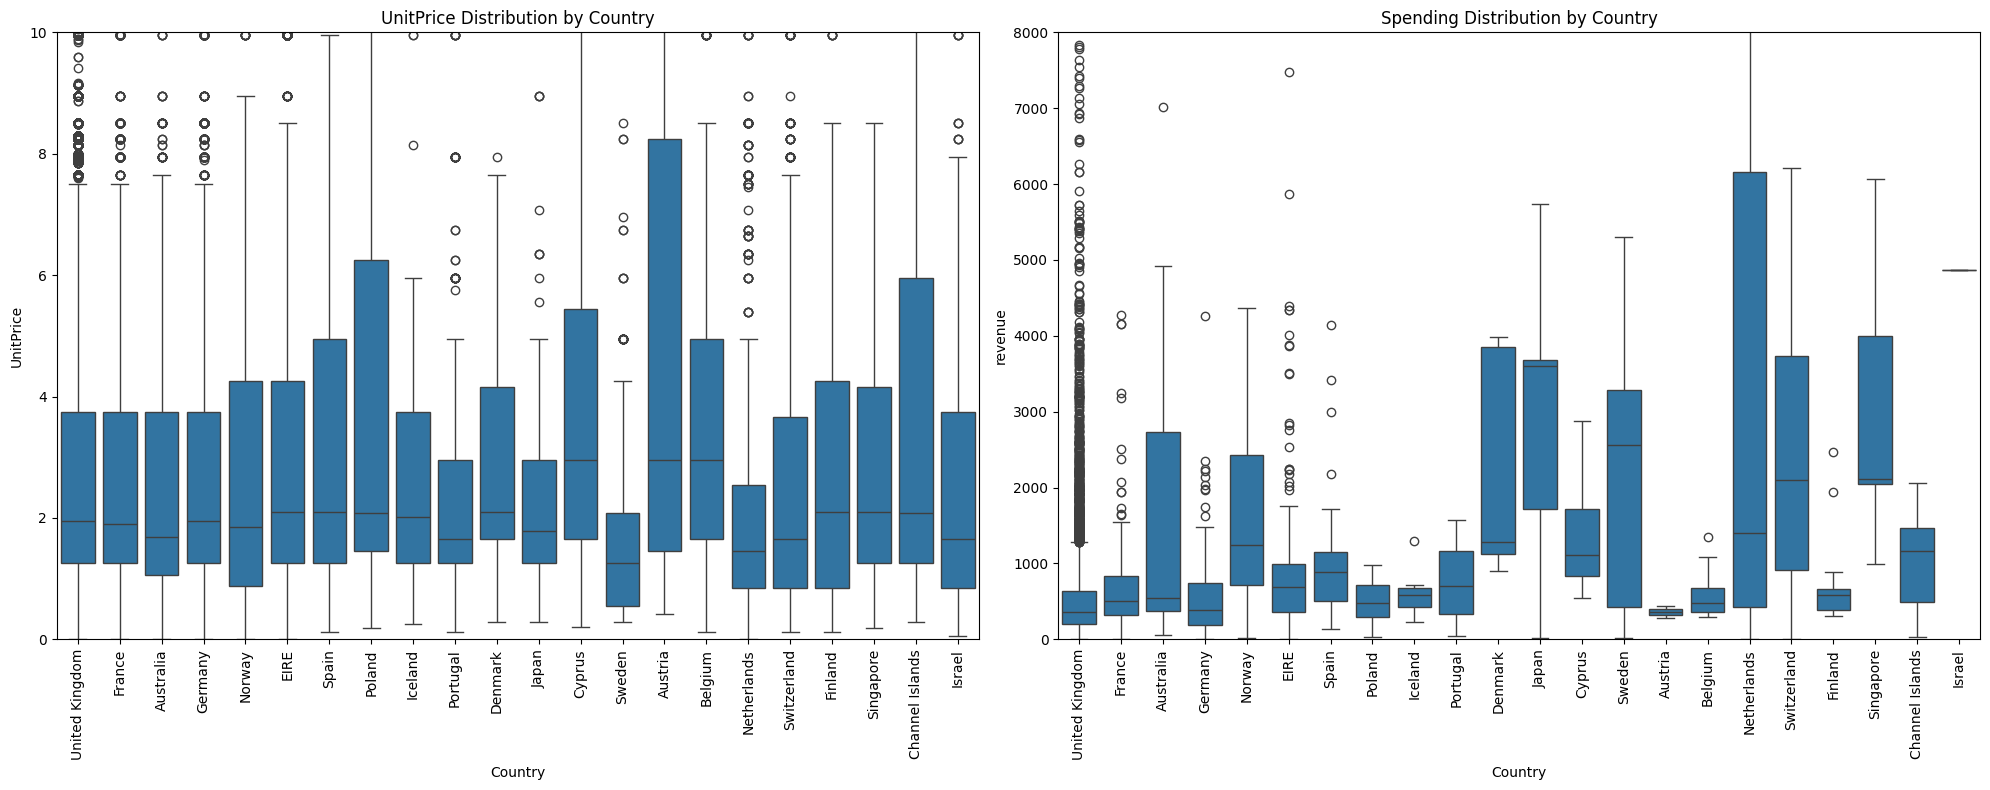

In [ ]:
#Apply the same above direction in distribution chart for top 10% customer by country

fig, axes = plt.subplots(1,2, figsize=(20,8))
ax = axes.flatten()

#Chart 1
sns.boxplot(data = top_10_customer_df, x = top_10_customer_df['Country'],y ='UnitPrice',ax =ax[0])
ax[0].set_ylim(0, 10)
ax[0].set_title('UnitPrice Distribution by Country')
ax[0].tick_params(axis='x', rotation=90)

#Chart 2
revenue_by_order_by_country = top_10_customer_df.groupby(['InvoiceNo', 'Country'])['revenue'].sum().reset_index()

sns.boxplot(data = revenue_by_order_by_country, x = 'Country', y ='revenue',ax =ax[1])
ax[1].set_ylim(0, 8000)
ax[1].set_title('Spending Distribution by Country')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

**Findings:**

Into both charts, I observe that:

+ **For most important customer group: UK**

**i. Unit Price:** Align with the pattern of total country, they buy for the low-medium price (more focusing into the low price as distribution) comparing to other countries

**ii. Spending per Order:** Resulting from the demand of UnitPrice, they have the value by each orders smaller than others

=> The winning in here is about **their frequency in orders purchasing as Frequent Shoppers group with economy products** , thanks to their buying behavior and amount of customers

### **A. RFM Analysis**

Self-concern: Diving into the above analysis of value customer, so what type of customers to group them ?

=> I base on the **RFM model concept by using the embed SQL** to analyze this as well as **answer for the Churn Improvement**

In [ ]:
!pip install pandasql
from pandasql import sqldf

def create_rfm_model(data):
    # Ensure 'InvoiceDate' is in datetime format
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

    # Convert any 'Period' columns to string
    if 'monthly' in data.columns and isinstance(data['monthly'].dtype, pd.core.dtypes.dtypes.PeriodDtype):
        data['monthly'] = data['monthly'].astype(str)

    max_date = data['InvoiceDate'].max()

    # SQL code range time = 1 year
    query = """
        select CustomerID
               , max(InvoiceDate) as latest_purchase_day
               , count(distinct InvoiceNo) as Frequency
               , sum(revenue)/count(distinct InvoiceNo) as Monetary
        from data
        group by CustomerID
    """
    rfm_df = sqldf(query, locals())

    # Calculate Recency
    rfm_df['Recency'] = (max_date - pd.to_datetime(rfm_df['latest_purchase_day'])).dt.days
    rfm_df = rfm_df.drop('latest_purchase_day', axis=1) # drop the no needed col

    # Calculate RFM scores
    rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 3, labels=[3, 2, 1])

    # Calculate quantiles without labels first to determine the number of unique bins
    frequency_quantiles = pd.qcut(rfm_df['Frequency'], 3, duplicates='drop')

    # Get the number of unique bins
    num_bins = frequency_quantiles.nunique()

    # Assign labels based on the number of unique bins
    rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'], 3, labels=list(range(1, num_bins + 1)), duplicates='drop')

    rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 3, labels=[1,2,3])

    # Map to RFM score
    rfm_df["rfm_score"] = rfm_df["R_score"].astype(str) + rfm_df["F_score"].astype(str) + rfm_df["M_score"].astype(str)

    def classify_RFM_group(row):
      rfm_score = row["rfm_score"]

      if rfm_score in ['333', '332', '323']:
        return 'Champions'
      elif rfm_score in ['321', '322', '331', '232', '233']:
        return 'Loyal'
      elif rfm_score in ['312', '313', '311', '222', '223']:
        return 'Recent'
      elif rfm_score in ['213', '221', '123', '132', '133']:
        return 'Needs attention'
      elif rfm_score in ['231', '212', '122', '131', '211']:
        return 'At risk'
      elif rfm_score in ['111', '112', '113', '121']:
         return 'Inactive'

    rfm_df['Customer_Group'] = rfm_df.apply(classify_RFM_group, axis=1)

    return rfm_df

rfm_model_datadf = create_rfm_model(data)
display(rfm_model_datadf)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CustomerID  Frequency     Monetary  Recency R_score F_score M_score  \
0            NaN       3525   410.634774        0       3       3       3   
1        12346.0          1     0.000000      325       1       1       1   
2        12347.0          7   615.714286        1       3       3       3   
3        12348.0          4   449.310000       74       2       2       3   
4        12349.0          1  1757.550000       18       3       1       3   
...          ...        ...          ...      ...     ...     ...     ...   
4368     18280.0          1   180.600000      277       1       1       1   
4369     18281.0          1    80.820000      180       1       1       1   
4370     18282.0          2    88.300000        7       3       2       1   
4371     18283.0         16   130.930000        3       3       3       1   
4372     18287.0          3   612.426667       42       2       2       3   

     rfm_score Customer_Group  
0          333      Champions  
1          111       Inactive  
2          333      Champions  
3          223         Recent  
4          313         Recent  
...        ...            ...  
4368       111       Inactive  
4369       111       Inactive  
4370       321          Loyal  
4371       331          Loyal  
4372       223         Recent  

[4373 rows x 9 columns]

**RFM Group Description**
+ **Champions:** The best customers
+ **Loyal:**	Valuable customers that are engaged
+ **Recent:**	Recent customers
+ **Needs attention:** A valuable customer that has not purchased recently
+ **At risk:**	A customer that has not purchased recently and/or tends to spend less overall
+ **Inactive:** A lapsed customer

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


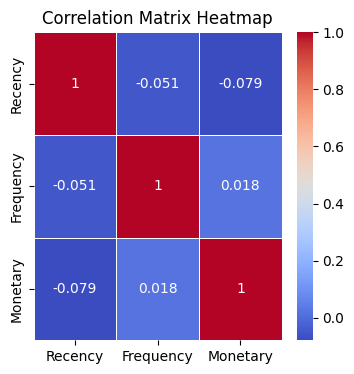

In [ ]:
# Corr between RFM

corr_matrix = rfm_model_datadf[['Recency', 'Frequency', 'Monetary']].corr()
plt.figure(figsize=(4,4))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Mapping the RFM definition to org dataframe

rfm_df = pd.merge(data, rfm_model_datadf[['CustomerID', 'Customer_Group']], on='CustomerID', how='left')

rfm_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day  month  monthly Customer_Group  
0 2010-12-01     12  2010-12        At risk  
1 2010-12-01     12  2010-12        At risk  
2 2010-12-01     12  2010-12        At risk  
3 2010-12-01     12  2010-12        At risk  
4 2010-12-01     12  2010-12        At risk

In [ ]:
# Apply the same approach to check for the performance of each Customer RFM Group
total_no_of_customers = data['CustomerID'].nunique()
total_revenue_of_customers = data['revenue'].sum()
total_orders_of_customers = data['InvoiceNo'].nunique()
total_quantity_of_customers = data['Quantity'].sum()

#Calculate the proportion
no_of_customers_total_rfm = rfm_df.groupby('Customer_Group')['CustomerID'].nunique()
revenue_of_total_rfm = rfm_df.groupby('Customer_Group')['revenue'].sum()
orders_of_total_rfm = rfm_df.groupby('Customer_Group')['InvoiceNo'].nunique()
quantity_of_total_rfm = rfm_df.groupby('Customer_Group')['Quantity'].sum()

pct_no_of_customers_total_rfm = round(no_of_customers_total_rfm*100/total_no_of_customers,1)
pct_revenue_total_rfm = round(revenue_of_total_rfm*100/total_revenue_of_customers,1)
pct_orders_total_rfm = round(orders_of_total_rfm*100/total_orders_of_customers,1)
pct_quantity_total_rfm = round(quantity_of_total_rfm*100/total_quantity_of_customers,1)

#Concat by index Country
concat_total_rfm = pd.concat([no_of_customers_total_rfm
                            ,pct_no_of_customers_total_rfm
                            ,revenue_of_total_rfm
                            ,pct_revenue_total_rfm
                            ,orders_of_total_rfm
                            ,pct_orders_total_rfm
                            ,quantity_of_total_rfm
                            ,pct_quantity_total_rfm
                            ], axis=1)

#Rename header
concat_total_rfm.columns = ['No. of Customers', '% No.Customers', 'Revenue', '% Revenue', 'Orders', '% No.Orders', 'Quantity', '% No.Quantity']

concat_total_rfm_sorted = concat_total_rfm.sort_values(by='% Revenue', ascending=False)

concat_total_rfm_sorted

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


No. of Customers  % No.Customers      Revenue  % Revenue  \
Customer_Group                                                              
Champions                     767            17.5  6527828.590       67.0   
Loyal                         777            17.8  1391076.380       14.3   
Recent                        616            14.1   636454.990        6.5   
Needs attention               575            13.2   585981.274        6.0   
Inactive                     1047            23.9   336450.470        3.5   
At risk                       557            12.7   280139.250        2.9   

                 Orders  % No.Orders   Quantity  % No.Quantity  
Customer_Group                                                  
Champions         11580         52.5  3176935.0           61.4  
Loyal              4894         22.2   848361.0           16.4  
Recent             1408          6.4   406293.0            7.8  
Needs attention    1405          6.4   368514.0            7.1  
Inactive           1367          6.2   203683.0            3.9  
At risk            1407          6.4   173464.0            3.4

**Findings:**

Regarding to the RFM groups contribution, the business is currently facing with pros and cons:

**+ Pros:** Having the big contribution from Champions group, meaning they're having a large pool to leverage for ensuring the performance

**+ Cons:** Despite huge in New Customers, it shows the struggle in converting them into higher-value phases and comes at churned stage

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


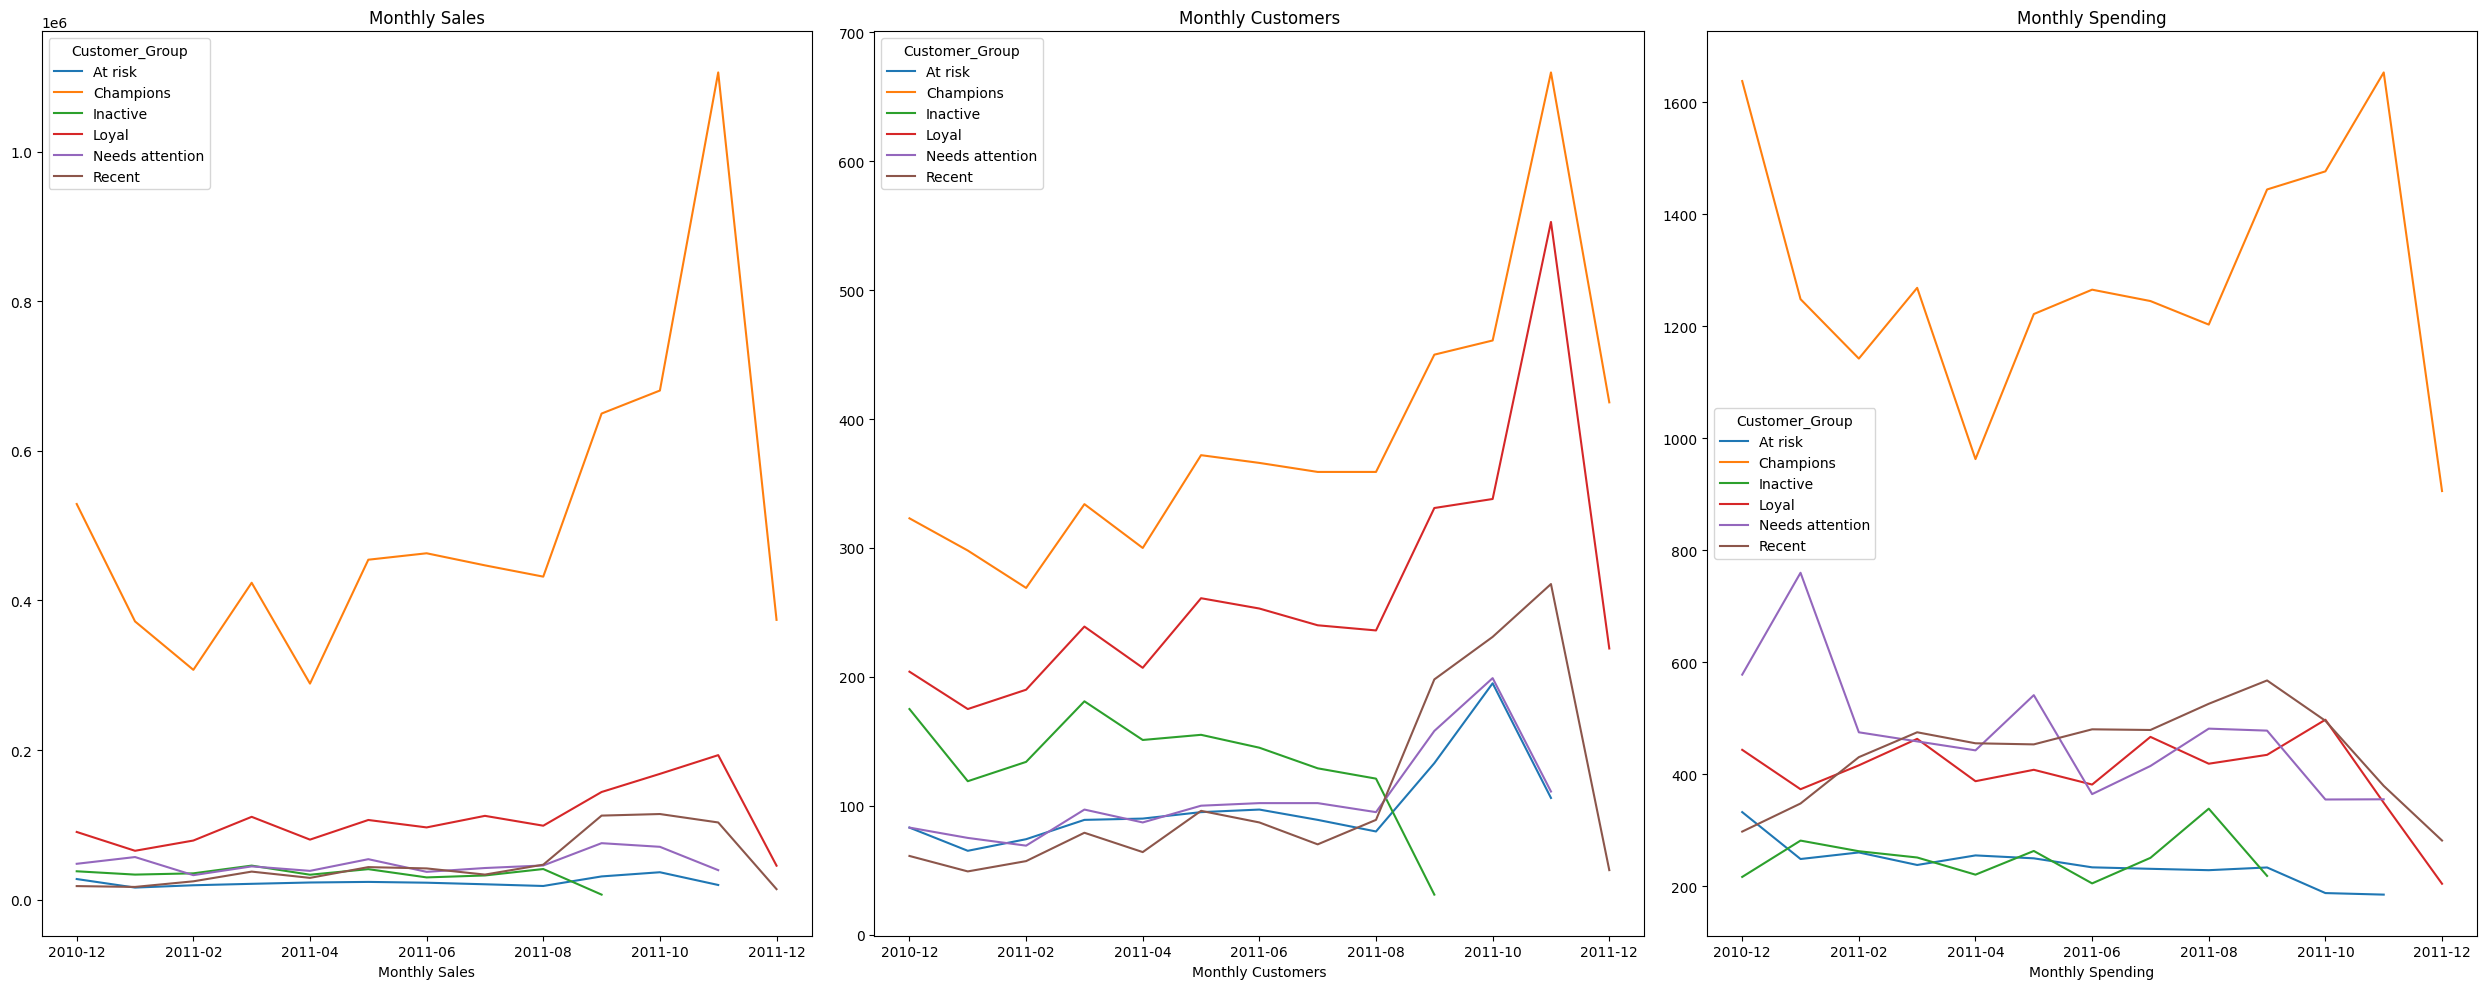

In [ ]:
# Seasonality check
fig, axes = plt.subplots(1,3, figsize=(25,10))
ax = axes.flatten()

rfm_df_chart = rfm_df.groupby('Customer_Group')['revenue'].sum().sort_values(ascending=False)

# Chart 1. Monthly Sales
monthly_sales_by_customer_group = rfm_df.groupby(['monthly', 'Customer_Group'])['revenue'].sum().reset_index()
monthly_sales_customer_group_pivot = monthly_sales_by_customer_group.pivot(index='monthly', columns='Customer_Group', values='revenue')

monthly_sales_customer_group_pivot.plot(kind='line',ax=ax[0])

ax[0].set_title('Monthly Sales')
ax[0].set_xlabel('Monthly Sales')

# Chart 2. Monthly No.Customers
monthly_number_by_customer_group = rfm_df.groupby(['monthly', 'Customer_Group'])['CustomerID'].nunique().reset_index()
monthly_number_customer_group_pivot = monthly_number_by_customer_group.pivot(index='monthly', columns='Customer_Group', values='CustomerID')

monthly_number_customer_group_pivot.plot(kind='line',ax=ax[1])

ax[1].set_title('Monthly Customers')
ax[1].set_xlabel('Monthly Customers')

# Chart 3. Monthly Spending
monthly_spending_customer_group = monthly_sales_customer_group_pivot / monthly_number_customer_group_pivot

monthly_spending_customer_group.plot(kind='line', ax=ax[2])

ax[2].set_title('Monthly Spending')
ax[2].set_xlabel('Monthly Spending')

plt.tight_layout()
plt.show()

**Findings:**

Due to the seasonality of each customer group, I find 2 key directions that:

* It appears the correlated pattern between Needs attention and Inactive group in the begining months of the year

* The key groups align with business patterns to maximize at the end of year via promoting olds and recruiting new

=> In a nutshell, **Begining of the year will needs protect actions**, and **End of year will take for amplify**



In [ ]:
# Apply RFM for the characteristics of top 10% customer
rfm_model_top_customer_define = create_rfm_model(top_10_customer_df)

rfm_model_top_customer_define.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-34-583714fc72e4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
<ipython-input-34-583714fc72e4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

CustomerID  Frequency     Monetary  Recency R_score F_score M_score  \
0     12347.0          7   615.714286        1       3       1       2   
1     12357.0          1  6207.670000       32       1       1       3   
2     12359.0          4  1561.382500        7       2       1       3   
3     12362.0         10   515.458000        2       3       2       2   
4     12370.0          4   886.422500       50       1       1       3   

  rfm_score   Customer_Group  
0       312           Recent  
1       113         Inactive  
2       213  Needs attention  
3       322            Loyal  
4       113         Inactive

In [ ]:
# Mapping the RFM definition to top customer dataframe

rfm_model_top_customer = pd.merge(top_10_customer_df, rfm_model_top_customer_define[['CustomerID', 'Customer_Group']], on='CustomerID', how='left')

rfm_model_top_customer.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day  month  monthly Customer_Group  
0 2010-12-01     12  2010-12        At risk  
1 2010-12-01     12  2010-12        At risk  
2 2010-12-01     12  2010-12        At risk  
3 2010-12-01     12  2010-12        At risk  
4 2010-12-01     12  2010-12        At risk

In [ ]:
# Apply the same from above in the internal of top customers
total_no_of_top_customers = rfm_model_top_customer['CustomerID'].nunique()
total_revenue_of_top_customers = rfm_model_top_customer['revenue'].sum()
total_orders_of_top_customers = rfm_model_top_customer['InvoiceNo'].nunique()
total_quantity_of_top_customers = rfm_model_top_customer['Quantity'].sum()

#Calculate
no_of_customers_top_customer_rfm = rfm_model_top_customer.groupby('Customer_Group')['CustomerID'].nunique()
revenue_of_top_customer_rfm = rfm_model_top_customer.groupby('Customer_Group')['revenue'].sum()
orders_of_top_customer_rfm = rfm_model_top_customer.groupby('Customer_Group')['InvoiceNo'].nunique()
quantity_of_top_customer_rfm = rfm_model_top_customer.groupby('Customer_Group')['Quantity'].sum()

pct_no_of_customers_top_customer_rfm = round(no_of_customers_top_customer_rfm*100/total_no_of_top_customers,1)
pct_revenuetop_customer_rfm = round(revenue_of_top_customer_rfm*100/total_revenue_of_top_customers,1)
pct_orders_top_customer_rfm = round(orders_of_top_customer_rfm*100/total_orders_of_top_customers,1)
pct_quantity_top_customer_rfm = round(quantity_of_top_customer_rfm*100/total_quantity_of_top_customers,1)

#Concat by index Country
concat_top_customer_rfm = pd.concat([no_of_customers_top_customer_rfm
                                    ,pct_no_of_customers_top_customer_rfm
                                    ,revenue_of_top_customer_rfm
                                    ,pct_revenuetop_customer_rfm
                                    ,orders_of_top_customer_rfm
                                    ,pct_orders_top_customer_rfm
                                    ,quantity_of_top_customer_rfm
                                    ,pct_quantity_top_customer_rfm
                                    ], axis=1)

#Rename header
concat_top_customer_rfm.columns = ['No. of Customers', '% No.Customers', 'Revenue', '% Revenue', 'Orders', '% No.Orders', 'Quantity', '% No.Quantity']

concat_top_customer_rfm_sorted = concat_top_customer_rfm.sort_values(by='% Revenue', ascending=False)

concat_top_customer_rfm_sorted

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


No. of Customers  % No.Customers     Revenue  % Revenue  \
Customer_Group                                                             
Champions                      49            11.2  1869154.55       37.5   
Loyal                          98            22.4  1135943.02       22.8   
Needs attention                68            15.5   634771.11       12.7   
Inactive                      101            23.1   540397.14       10.8   
At risk                        78            17.8   444867.08        8.9   
Recent                         44            10.0   358869.48        7.2   

                 Orders  % No.Orders   Quantity  % No.Quantity  
Customer_Group                                                  
Champions          1763         24.3  1065920.0           37.3  
Loyal              2464         34.0   648790.0           22.7  
Needs attention     745         10.3   369495.0           12.9  
Inactive            677          9.3   324207.0           11.3  
At risk            1192         16.4   265087.0            9.3  
Recent              408          5.6   183795.0            6.4

**Findings:**

Positively, most of the high revenue contributor belongs to the **Champions group**.

However, it still shows the high pct revenue in **At Risk group** and pct customers in **Lost & At Risk groups**

=> These need to be protected to gain back before getting churns

=> The actions could be seperated by the above mentioned direction of country-focus and their specific demands of products

Moreover, diving to see the factors leading to the churn reason for preventing and limiting it

### **B. Churn Analysis**

**Strategic Approach:** Segment customers based on:

* **Value Index:** Are they worth caring about?
* **Churn Index:** Are they at risk to be protected from churn?

.

**1. Value Index**
=> Based on 2 indices:** M (Monetary / Month)** and **F (Frequency / Month)** with a **ratio of 7:3**

-> In this case, we care more about their spending.

**2. Churn Index** - Currently, we only have the Date they bought.
=> Therefore, define based on 2 indices: **R - Recency** (Number of latest months since their last purchase) and **Decline in monthly spending** (Meaning not spending much anymore) with a **ratio of 7:3**

-> In this case, we care more about maintaining them.

In [ ]:
df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day  
0 2010-12-01  
1 2010-12-01  
2 2010-12-01  
3 2010-12-01  
4 2010-12-01

**(i) Value Index**

In [ ]:
# Create new dataframe
churn_df = df.copy()

# Cleaning
churn_df['Quantity'] = pd.to_numeric(churn_df['Quantity'], errors='coerce')
churn_df['UnitPrice'] = pd.to_numeric(churn_df['UnitPrice'], errors='coerce')

churn_df['month'] = pd.to_datetime(churn_df['InvoiceDate']).dt.month
churn_df['revenue'] = churn_df['Quantity']*churn_df['UnitPrice']

churn_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day  month  
0 2010-12-01     12  
1 2010-12-01     12  
2 2010-12-01     12  
3 2010-12-01     12  
4 2010-12-01     12

In [ ]:
# Calculate - Value Index

# M
total_moneytary = churn_df.groupby(['CustomerID','month'])['revenue'].sum()
monthly_moneytary = total_moneytary.groupby('CustomerID').mean().reset_index(name = 'monthly_moneytary')

# F
total_orders = churn_df.groupby(['CustomerID','month'])['InvoiceNo'].nunique()
monthly_frequency = total_orders.groupby('CustomerID').mean().reset_index(name = 'monthly_frequency')

# Create value index df
value_index_df = pd.merge(monthly_moneytary, monthly_frequency, on = 'CustomerID', how = 'left')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
value_normalize = pd.DataFrame(value_index_df)

value_normalize = value_normalize.rename(columns={ 0 : 'monthly_moneytary'
                                                 , 1 : 'monthly_frequency'
                                                 })

value_normalize.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CustomerID  monthly_moneytary  monthly_frequency
0     12346.0           0.000000           1.000000
1     12347.0         718.333333           1.166667
2     12348.0         449.310000           1.000000
3     12349.0        1757.550000           1.000000
4     12350.0         334.400000           1.000000

In [ ]:
# Apply proportion để generate value rating index
## 70% monthly_moneytary (M)
## 30% monthly_frequency (F)

value_normalize['value_rating_index'] = 0.7*value_normalize['monthly_moneytary'] \
                                        + 0.3*value_normalize['monthly_frequency']

value_normalize.describe().T.round(2)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count      mean      std       min       25%       50%  \
CustomerID          4372.0  15299.68  1722.39  12346.00  13812.75  15300.50   
monthly_moneytary   4372.0    451.03   848.93  -4287.63    182.52    310.26   
monthly_frequency   4372.0      1.19     0.68      0.00      1.00      1.00   
value_rating_index  4372.0    316.08   594.35  -3001.34    128.07    217.60   

                         75%       max  
CustomerID          16778.25  18287.00  
monthly_moneytary     492.87  23312.59  
monthly_frequency       1.25     17.50  
value_rating_index    345.32  16320.45

=> **Thresholds** to classify for value index is **mean**

**(ii) Churn Index**

In [ ]:
# R
max_date = pd.to_datetime(churn_df['InvoiceDate']).max()
latest_recency = churn_df.groupby(['CustomerID'])['InvoiceDate'].max().reset_index(name = 'latest_purchase')
latest_recency['last_return'] = (max_date - pd.to_datetime(latest_recency['latest_purchase'])).dt.days

# drop cột latest_purchase sau khi done calculation
latest_recency = latest_recency.drop('latest_purchase', axis = 1)

latest_recency.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CustomerID  last_return
0     12346.0          325
1     12347.0            1
2     12348.0           74
3     12349.0           18
4     12350.0          309

In [ ]:
# Calculate MoM Growth
# Decline in monthly spending - leverage the monthly moneytary above

total_moneytary = total_moneytary.reset_index()
total_moneytary_pv = pd.pivot_table(total_moneytary, index = 'month', columns = 'CustomerID', values = 'revenue', aggfunc = 'sum').fillna(0)

# Create dict
customer_growth = {}

# Calculate MoM growth using a for loop
for customer in total_moneytary_pv.columns:
    purchase_month = total_moneytary_pv.index[total_moneytary_pv[customer] > 0] # Select các tháng có purchase (value > 0)

    if len(purchase_month) > 1:  # Check if there are at least 2 months with positive revenue
        revenue_values = total_moneytary_pv.loc[purchase_month, customer].values  # Start with the first positive revenue month

        # Calculate Growth rate
        growth_rates = []
        for i in range(1, len(revenue_values)):
            growth_rate = (revenue_values[i] - revenue_values[i - 1]) / revenue_values[i - 1]
            growth_rates.append(growth_rate)

        avg_growth = sum(growth_rates) / len(growth_rates) if growth_rates else 0

        # Store avg_growth with CustomerID in the dictionary
        customer_growth[customer] = avg_growth

# Create a DataFrame from the dictionary
customer_growth_df = pd.DataFrame(list(customer_growth.items()), columns=['CustomerID', 'avg_growth'])
# Display the DataFrame
customer_growth_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CustomerID  avg_growth
0     12347.0    0.281033
1     12348.0    0.779433
2     12352.0    0.198797
3     12356.0   -0.833430
4     12358.0    0.409067

In [ ]:
# Map two metrics to create churn index
churn_rating_index = pd.merge(latest_recency, customer_growth_df, on='CustomerID', how = 'left')

# Define Joined Customer and Previous Customer group
churn_rating_index.loc[churn_rating_index['avg_growth'].isnull(), 'customer_status'] = 'Joined'
churn_rating_index.loc[churn_rating_index['avg_growth'].notna(), 'customer_status'] = 'Old'

# Standardize data
from sklearn.preprocessing import StandardScaler

churn_rating_index_standardize = churn_rating_index[['last_return','avg_growth']]

scaler = StandardScaler()
churn_rating_index_scaled = scaler.fit_transform(churn_rating_index_standardize)

# Statistics
pd.DataFrame(churn_rating_index_scaled).describe().T.round(2)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count  mean  std   min   25%   50%   75%    max
0  4372.0  -0.0  1.0 -0.90 -0.74 -0.42  0.51   2.80
1  2687.0  -0.0  1.0 -0.03 -0.03 -0.03 -0.03  49.98

In [ ]:
churn_normalize = pd.DataFrame(churn_rating_index_scaled).rename(columns={ 0 : 'last_return'
                                                                         , 1 : 'avg_growth'
                                                                         })
# Map Churn to the CustomerID
churn_normalize = pd.merge(churn_normalize, churn_rating_index[['CustomerID','customer_status']], left_index=True, right_index=True, how='left')

churn_normalize.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


last_return  avg_growth  CustomerID customer_status
0     2.322023         NaN     12346.0          Joined
1    -0.893733   -0.026379     12347.0             Old
2    -0.169196   -0.026379     12348.0             Old
3    -0.725005         NaN     12349.0          Joined
4     2.163220         NaN     12350.0          Joined

In [ ]:
# Apply proportion để generate churn rating index
## 70% last_return
## 30% avg_growth

churn_normalize['churn_rating_index'] = 0.7*churn_normalize['last_return'] \
                                        + 0.3*(-churn_normalize['avg_growth']) # Negative avg_growth due to spending deceleration

# Cover case avg_growth isnull
churn_normalize['churn_rating_index'] = churn_normalize['churn_rating_index'].fillna(churn_normalize['last_return'])

churn_normalize.describe().T.round(2)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count      mean      std       min       25%       50%  \
last_return         4372.0     -0.00     1.00     -0.90     -0.74     -0.42   
avg_growth          2687.0     -0.00     1.00     -0.03     -0.03     -0.03   
CustomerID          4372.0  15299.68  1722.39  12346.00  13812.75  15300.50   
churn_rating_index  4372.0      0.07     0.93    -14.50     -0.56     -0.33   

                         75%       max  
last_return             0.51      2.80  
avg_growth             -0.03     49.98  
CustomerID          16778.25  18287.00  
churn_rating_index      0.42      2.80

=> **Mean = 0.02** will be the threshold

In [ ]:
# Define churn group base on thresholds

churn_normalize.loc[((churn_normalize['churn_rating_index'] >= 0.02) & (churn_normalize['customer_status'] == 'Joined')), 'churn_status'] = 'Joined Safe'
churn_normalize.loc[((churn_normalize['churn_rating_index'] < 0.02) & (churn_normalize['customer_status'] == 'Joined')), 'churn_status'] = 'Joined Risk'
churn_normalize.loc[((churn_normalize['churn_rating_index'] >= 0.02) & (churn_normalize['customer_status'] == 'Old')), 'churn_status'] = 'Old Safe'
churn_normalize.loc[((churn_normalize['churn_rating_index'] < 0.02) & (churn_normalize['customer_status'] == 'Old')), 'churn_status'] = 'Old Risk'

churn_normalize.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


last_return  avg_growth  CustomerID customer_status  churn_rating_index  \
0     2.322023         NaN     12346.0          Joined            2.322023   
1    -0.893733   -0.026379     12347.0             Old           -0.617700   
2    -0.169196   -0.026379     12348.0             Old           -0.110523   
3    -0.725005         NaN     12349.0          Joined           -0.725005   
4     2.163220         NaN     12350.0          Joined            2.163220   

  churn_status  
0  Joined Safe  
1     Old Risk  
2     Old Risk  
3  Joined Risk  
4  Joined Safe

(iii) Map Index of Value and Churn into 1 dataframe

In [ ]:
# Map for the final dataframe
rating_index = pd.merge(churn_normalize[['CustomerID','churn_status','customer_status','churn_rating_index']], value_normalize['value_rating_index'], left_index=True, right_index=True, how='left')

rating_index.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CustomerID churn_status customer_status  churn_rating_index  \
0     12346.0  Joined Safe          Joined            2.322023   
1     12347.0     Old Risk             Old           -0.617700   
2     12348.0     Old Risk             Old           -0.110523   
3     12349.0  Joined Risk          Joined           -0.725005   
4     12350.0  Joined Safe          Joined            2.163220   

   value_rating_index  
0            0.300000  
1          503.183333  
2          314.817000  
3         1230.585000  
4          234.380000

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


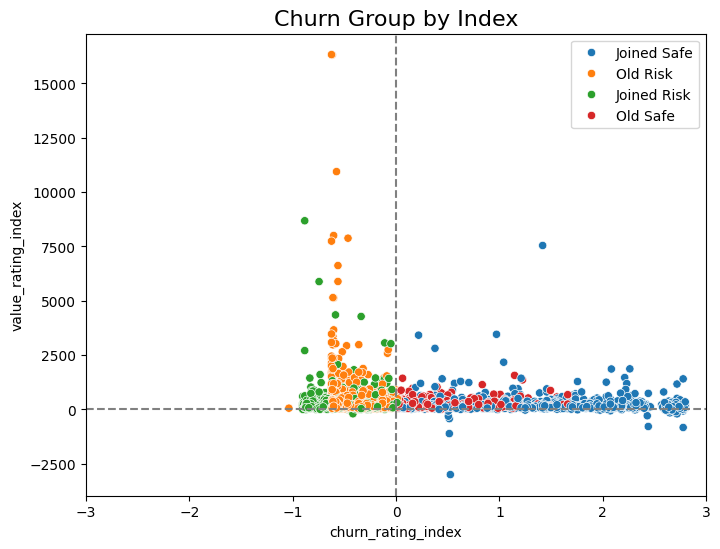

In [ ]:
# Visualize !!!!!!

plt.figure(figsize=(8, 6))

sns.scatterplot(rating_index, x = 'churn_rating_index',y = 'value_rating_index',hue = 'churn_status')

# Add line
plt.axhline(y=0, color='grey', linestyle='--')
plt.axvline(x=0, color='grey', linestyle='--')

# Set x,y-axis range to filter outlier
plt.xlim(-3, 3)
# plt.ylim(-5, 15)

plt.title('Churn Group by Index', fontsize=16)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


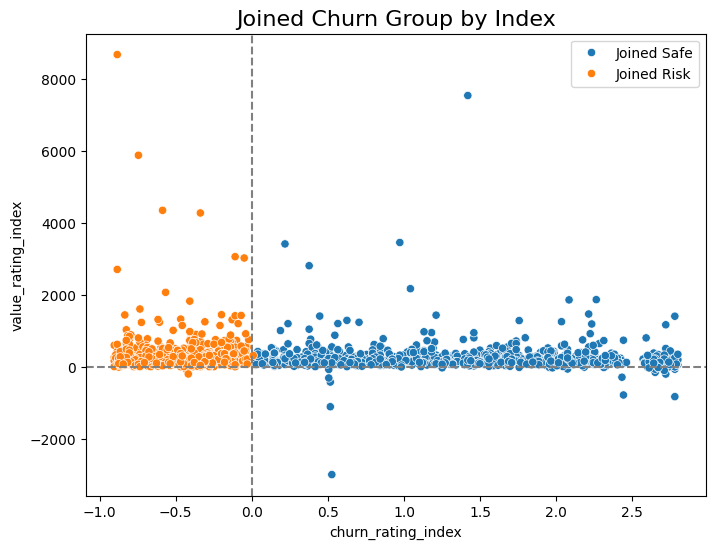

In [ ]:
# Visualize for newly joined
plt.figure(figsize=(8, 6))

rating_index_joined = rating_index[rating_index['customer_status'] == 'Joined']
sns.scatterplot(rating_index_joined, x = 'churn_rating_index',y = 'value_rating_index',hue = 'churn_status')

# Add line
plt.axhline(y=0, color='grey', linestyle='--')
plt.axvline(x=0, color='grey', linestyle='--')

## Set x,y-axis range to filter outlier
# plt.xlim(-3, 3)
# plt.ylim(-5, 15)

plt.title('Joined Churn Group by Index', fontsize=16)
plt.legend()
plt.show()

## **2. Churn Improvement**

# **V. Advanced Modelling**

## **1. K-means Clustering**

In [ ]:
# Import Libraries
!pip install scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k_mean = rfm_model_top_customer_define[['Frequency','Monetary','Recency']].copy()
k_mean.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Frequency     Monetary  Recency
0          7   615.714286        1
1          1  6207.670000       32
2          4  1561.382500        7
3         10   515.458000        2
4          4   886.422500       50

In [ ]:
# Standardize dataset

scaler = StandardScaler()

scaled_columns = k_mean.columns

k_mean[scaled_columns] = scaler.fit_transform(k_mean[scaled_columns])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


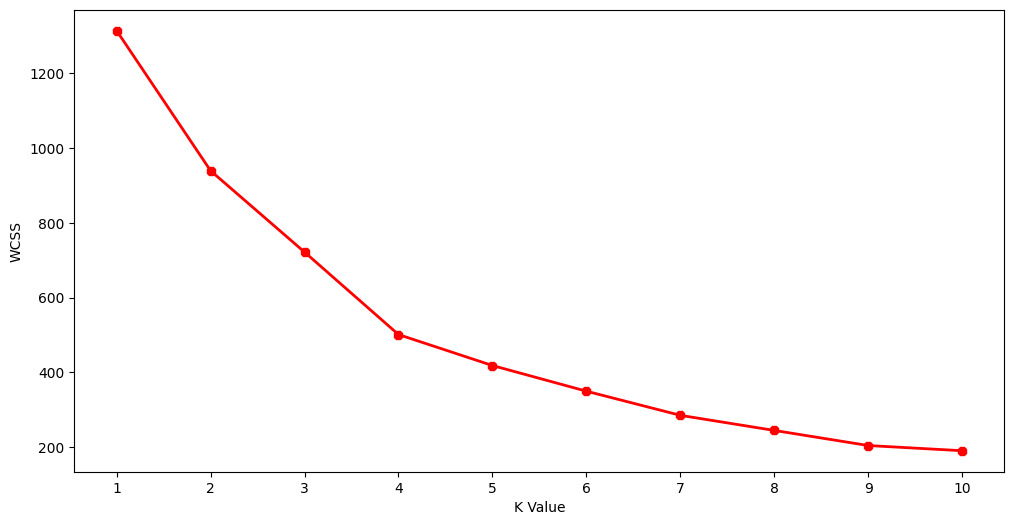

In [ ]:
wcss = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(k_mean)
    wcss.append(kmeans.inertia_)

#Visualize
plt.figure(figsize=(12,6))
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")

plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")

plt.show()

=> Select **K = 4** as Elbow

In [ ]:
# Make Clustering
K_C = KMeans(n_clusters = 4)
yhat_KC = K_C.fit_predict(k_mean)
k_mean["Cluster"]= yhat_KC +1

k_mean.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Frequency  Monetary   Recency  Cluster
0  -0.501604 -0.221305 -0.526908        1
1  -0.816740  6.003927  0.267668        3
2  -0.659172  0.831458 -0.373120        1
3  -0.344036 -0.332915 -0.501277        1
4  -0.659172  0.080060  0.729034        1

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


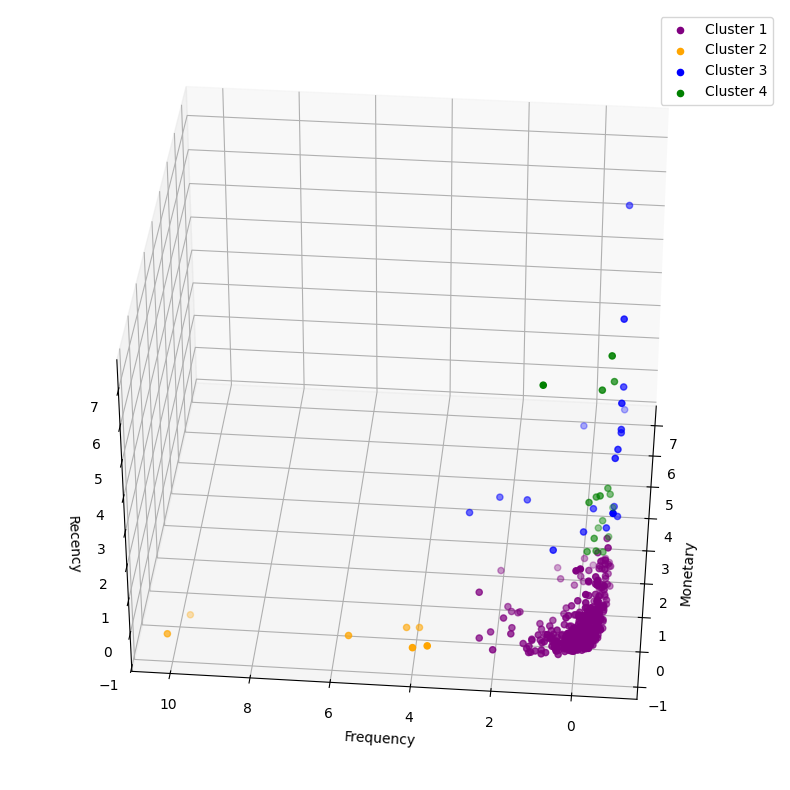

In [ ]:
#3D Plot visualization

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

# Visualize
ax.scatter(k_mean["Monetary"][k_mean['Cluster'] == 1], k_mean["Frequency"][k_mean['Cluster'] == 1], k_mean["Recency"][k_mean['Cluster'] == 1], c='purple', label='Cluster 1')
ax.scatter(k_mean["Monetary"][k_mean['Cluster'] == 2], k_mean["Frequency"][k_mean['Cluster'] == 2], k_mean["Recency"][k_mean['Cluster'] == 2], c='orange', label='Cluster 2')
ax.scatter(k_mean["Monetary"][k_mean['Cluster'] == 3], k_mean["Frequency"][k_mean['Cluster'] == 3], k_mean["Recency"][k_mean['Cluster'] == 3], c='blue', label='Cluster 3')
ax.scatter(k_mean["Monetary"][k_mean['Cluster'] == 4], k_mean["Frequency"][k_mean['Cluster'] == 4], k_mean["Recency"][k_mean['Cluster'] == 4], c='green', label='Cluster 4')

ax.view_init(35, 185)

# Switched labels for x and y axes
plt.xlabel("Monetary")
plt.ylabel("Frequency")
ax.set_zlabel('Recency')
ax.legend()

plt.show()

## **2. Compare between RFM vs K-means**

In [ ]:
# First to combine

p2_df = rfm_model_top_customer_define.copy()

p2_df['Cluster'] = k_mean['Cluster']

p2_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CustomerID  Frequency     Monetary  Recency R_score F_score M_score  \
0     12347.0          7   615.714286        1       3       1       2   
1     12357.0          1  6207.670000       32       1       1       3   
2     12359.0          4  1561.382500        7       2       1       3   
3     12362.0         10   515.458000        2       3       2       2   
4     12370.0          4   886.422500       50       1       1       3   

  rfm_score   Customer_Group  Cluster  
0       312           Recent        1  
1       113         Inactive        3  
2       213  Needs attention        1  
3       322            Loyal        1  
4       113         Inactive        1

In [ ]:
p2_df['Customer_Group'].unique()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Recent', 'Inactive', 'Needs attention', 'Loyal', 'At risk',
       'Champions'], dtype=object)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


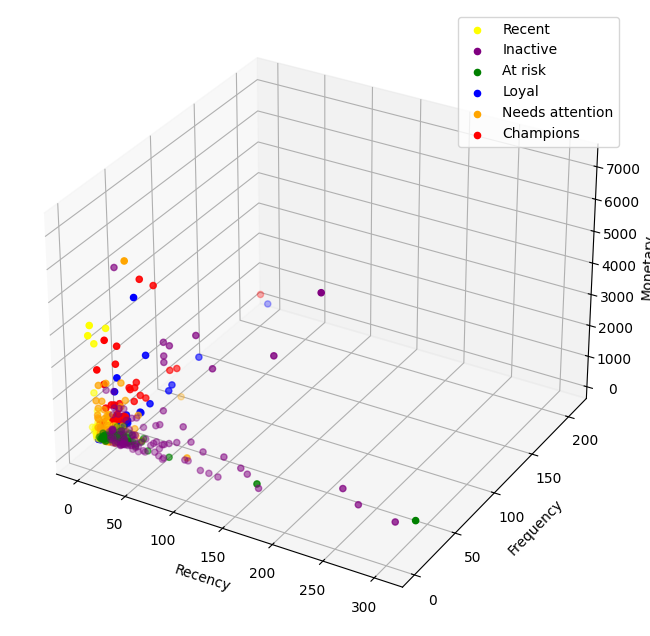

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(p2_df["Recency"][p2_df['Customer_Group'] == 'Recent'],
           p2_df["Frequency"][p2_df['Customer_Group'] == 'Recent'],
           p2_df["Monetary"][p2_df['Customer_Group'] == 'Recent'],
           c='yellow', label='Recent')

ax.scatter(p2_df["Recency"][p2_df['Customer_Group'] == 'Inactive'],
           p2_df["Frequency"][p2_df['Customer_Group'] == 'Inactive'],
           p2_df["Monetary"][p2_df['Customer_Group'] == 'Inactive'],
           c='purple', label='Inactive')

ax.scatter(p2_df["Recency"][p2_df['Customer_Group'] == 'At risk'],
           p2_df["Frequency"][p2_df['Customer_Group'] == 'At risk'],
           p2_df["Monetary"][p2_df['Customer_Group'] == 'At risk'],
           c='green', label='At risk')

ax.scatter(p2_df["Recency"][p2_df['Customer_Group'] == 'Loyal'],
           p2_df["Frequency"][p2_df['Customer_Group'] == 'Loyal'],
           p2_df["Monetary"][p2_df['Customer_Group'] == 'Loyal'],
           c='blue', label='Loyal')

ax.scatter(p2_df["Recency"][p2_df['Customer_Group'] == 'Needs attention'],
           p2_df["Frequency"][p2_df['Customer_Group'] == 'Needs attention'],
           p2_df["Monetary"][p2_df['Customer_Group'] == 'Needs attention'],
           c='orange', label='Needs attention')

ax.scatter(p2_df["Recency"][p2_df['Customer_Group'] == 'Champions'],
           p2_df["Frequency"][p2_df['Customer_Group'] == 'Champions'],
           p2_df["Monetary"][p2_df['Customer_Group'] == 'Champions'],
           c='red', label='Champions')

# Set labels
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


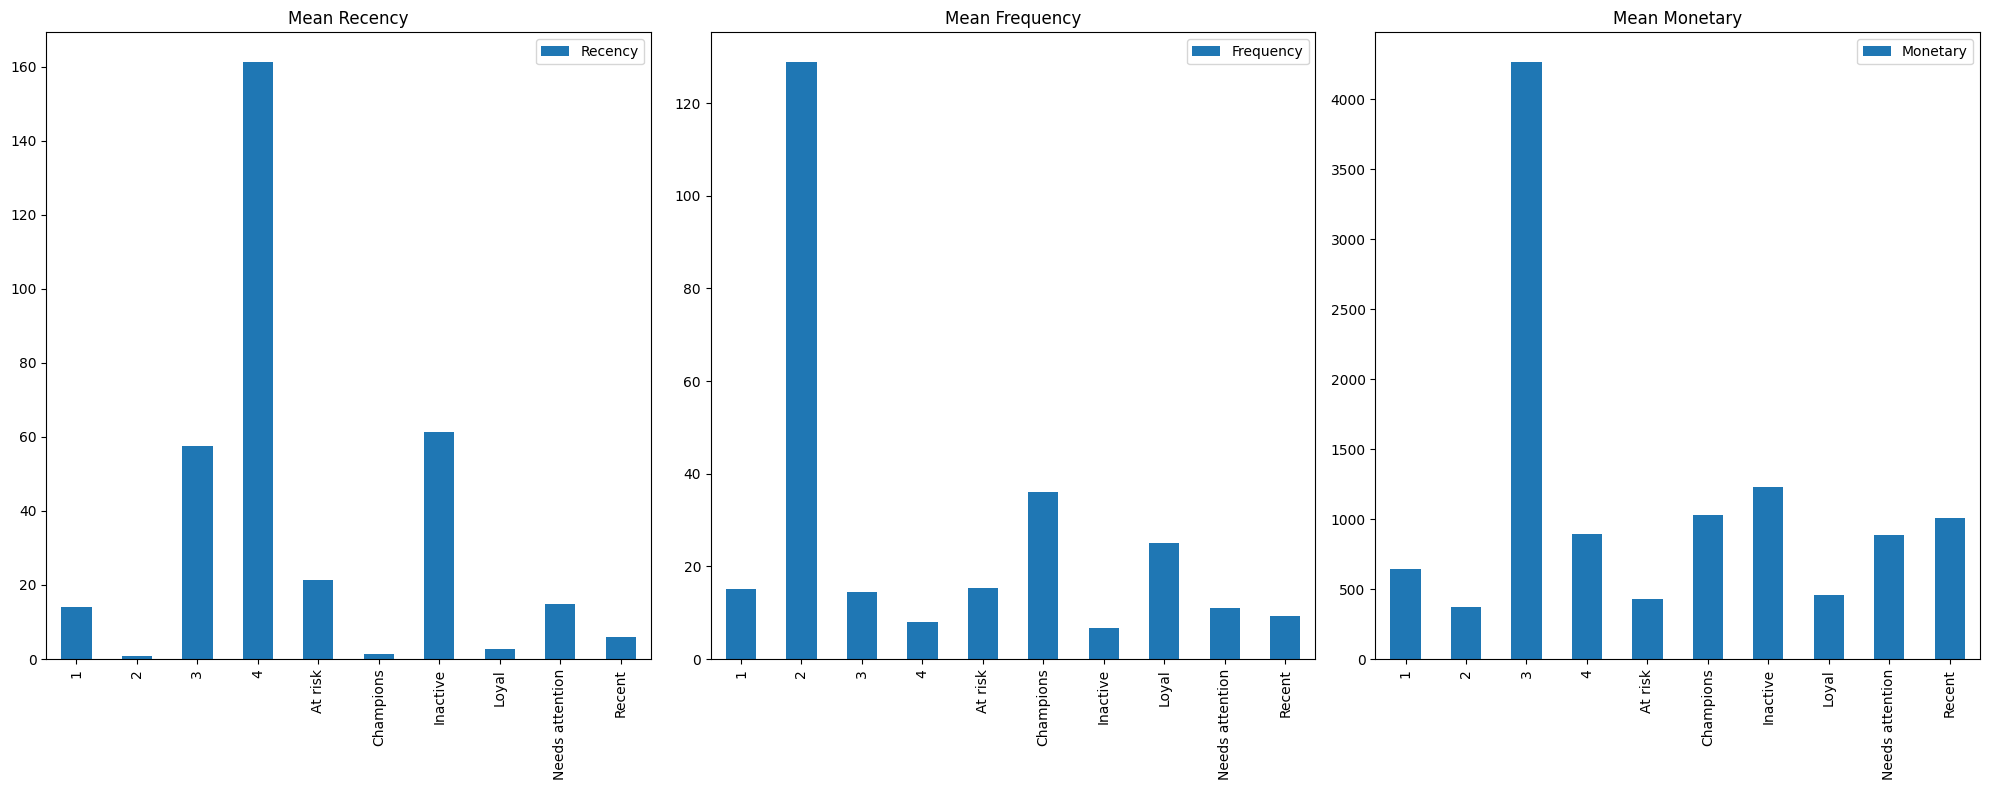

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,8))
ax = axes.flatten()

# Visualize
# R
r_cluster = p2_df.pivot_table(index='Cluster', values='Recency', aggfunc='mean')
r_rfm = p2_df.pivot_table(index='Customer_Group', values='Recency', aggfunc='mean')

r_concat = pd.concat([r_cluster, r_rfm])
r_concat.plot(kind = 'bar', ax = ax[0])
ax[0].set_title('Mean Recency')

# F
f_cluster = p2_df.pivot_table(index='Cluster', values='Frequency', aggfunc='mean')
f_rfm = p2_df.pivot_table(index='Customer_Group', values='Frequency', aggfunc='mean')

f_concat = pd.concat([f_cluster, f_rfm])
f_concat.plot(kind = 'bar', ax = ax[1])
ax[1].set_title('Mean Frequency')

# M
m_cluster = p2_df.pivot_table(index='Cluster', values='Monetary', aggfunc='mean')
m_rfm = p2_df.pivot_table(index='Customer_Group', values='Monetary', aggfunc='mean')

m_concat = pd.concat([m_cluster, m_rfm])
m_concat.plot(kind = 'bar', ax = ax[2])
ax[2].set_title('Mean Monetary')

plt.tight_layout()
plt.show()

In [ ]:
# Merge the Clustering and Customer_group into the org dataframe
merge_cluster_rfm = pd.merge(rfm_df, p2_df[['Cluster','CustomerID']], on = 'CustomerID', how = 'left')

# Calculate the metrics
merge_cluster_rfm_cal = merge_cluster_rfm.groupby(['Cluster','CustomerID','Customer_Group']) \
                                         .agg ( avg_quantity = ('Quantity','median')
                                              , avg_price = ('UnitPrice','median')
                                              , repeats = ('InvoiceNo','nunique')
                                              , product_variety = ('Description','nunique')
                                         )

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Reset the index to convert all to the columns to visualize
merge_cluster_rfm_cal_chart = merge_cluster_rfm_cal.reset_index()

merge_cluster_rfm_cal_chart.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster  CustomerID Customer_Group  avg_quantity  avg_price  repeats  \
0      1.0     12347.0      Champions          12.0      2.015        7   
1      1.0     12359.0      Champions           4.0      4.200        4   
2      1.0     12362.0      Champions           6.0      2.550       10   
3      1.0     12370.0         Recent           8.0      2.100        4   
4      1.0     12417.0      Champions           4.0      3.750        9   

   product_variety  
0              103  
1              213  
2              201  
3              143  
4              159

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


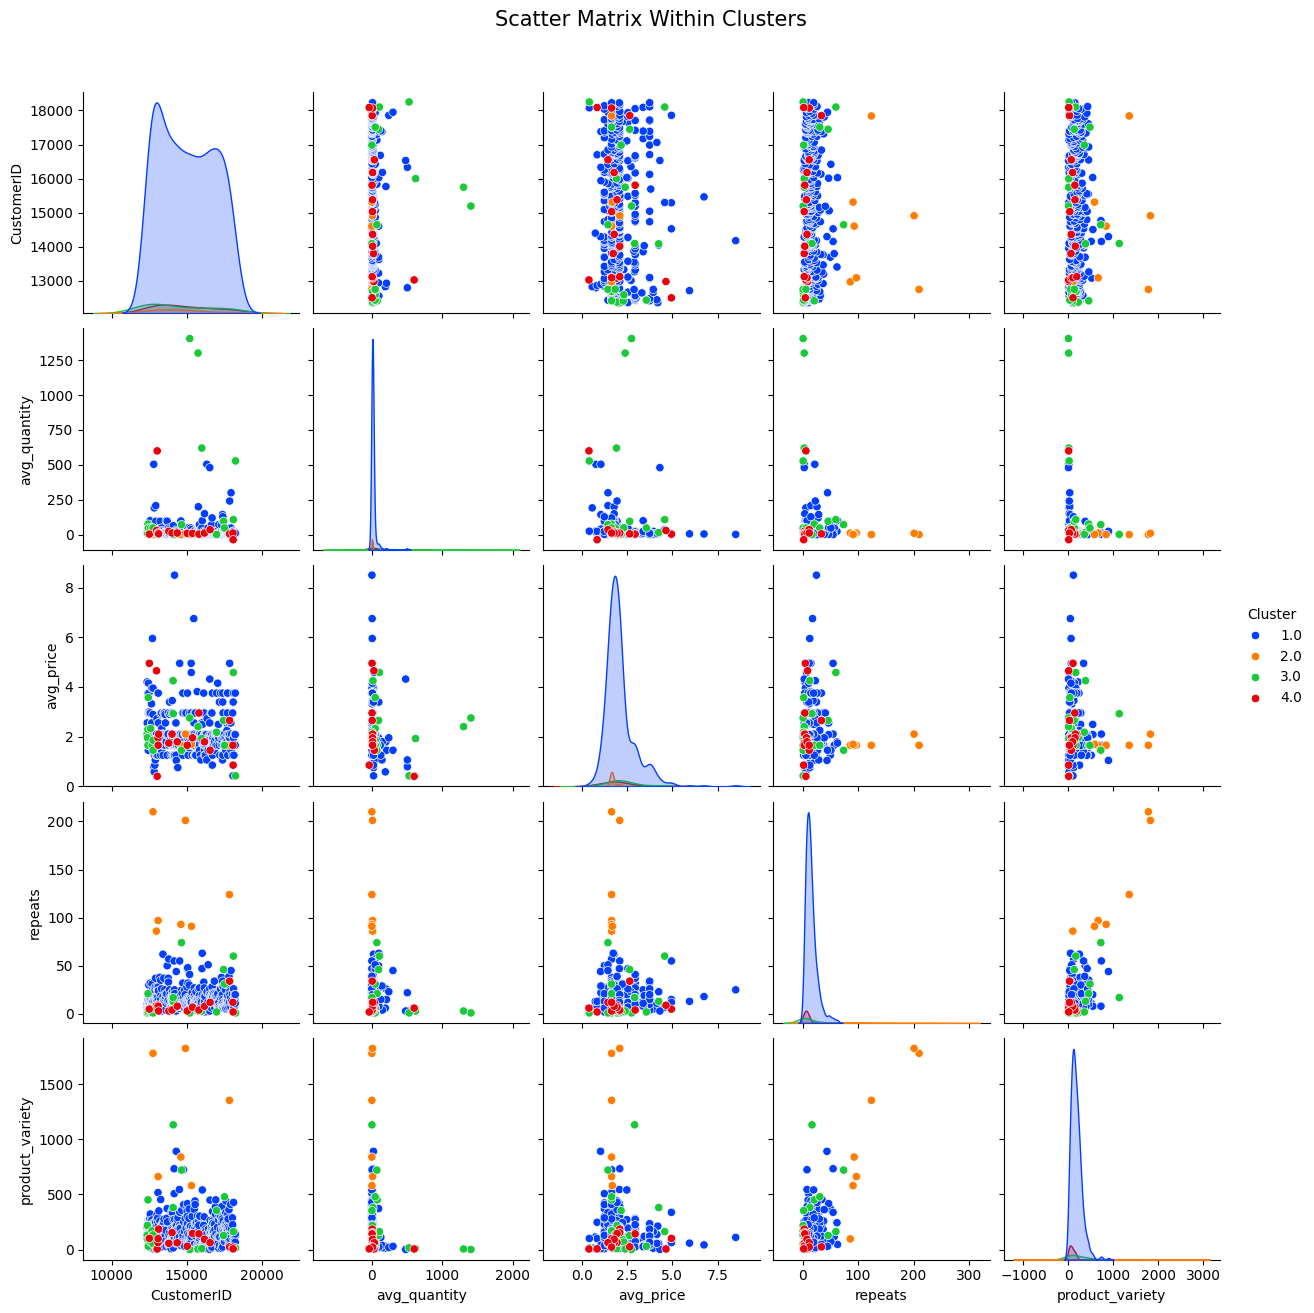

In [ ]:
# Visualize for the Cluster
sns.pairplot(merge_cluster_rfm_cal_chart, hue='Cluster', palette='bright')

plt.suptitle('Scatter Matrix Within Clusters', fontsize=15, y=1.05)

plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


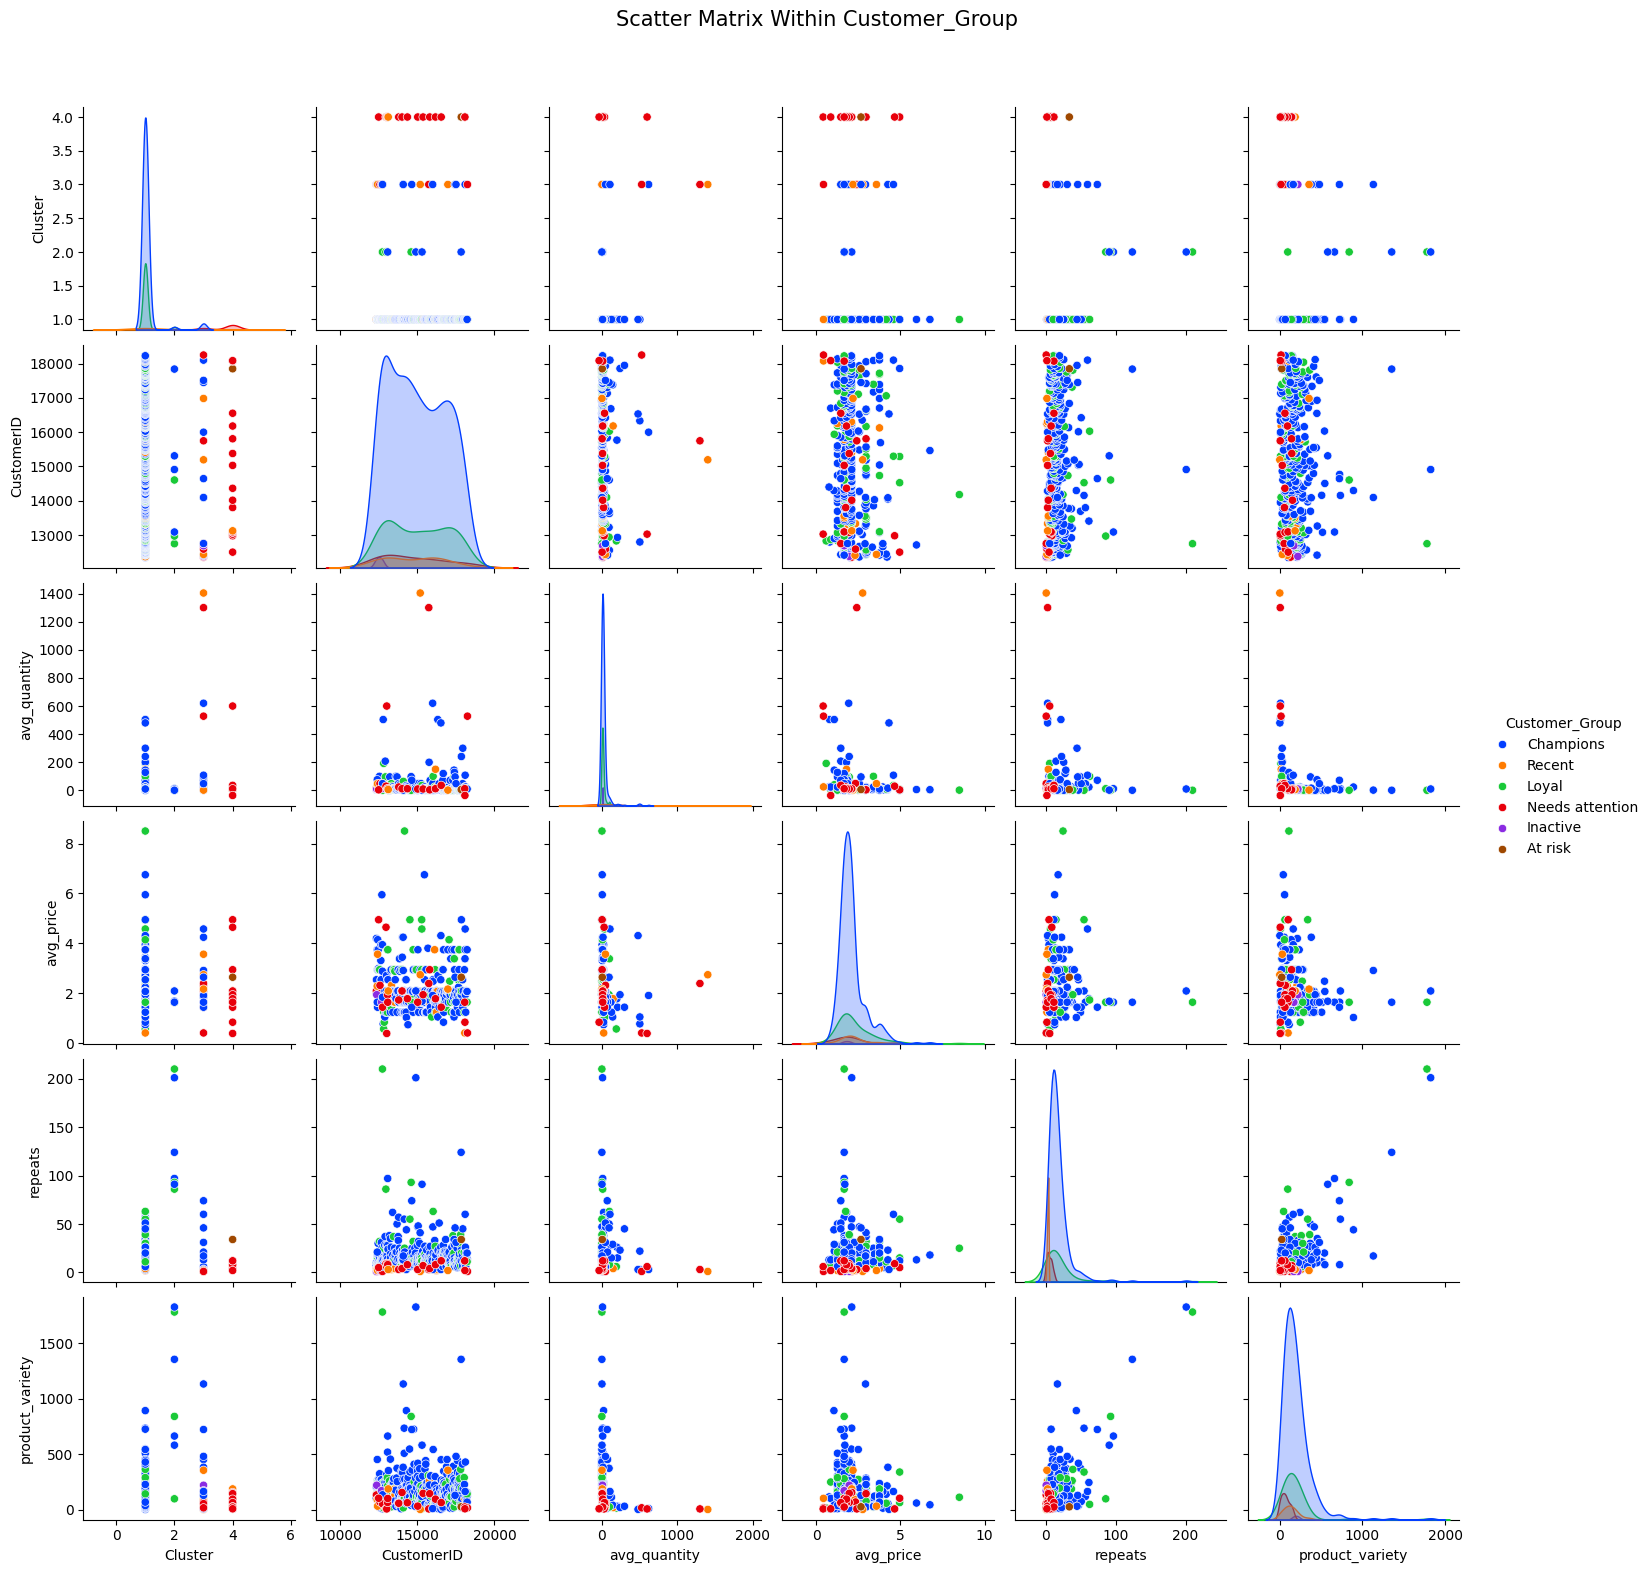

In [ ]:
# Visualize for the Customer_Group
sns.pairplot(merge_cluster_rfm_cal_chart, hue='Customer_Group', palette='bright')

plt.suptitle('Scatter Matrix Within Customer_Group', fontsize=15, y=1.05)

plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


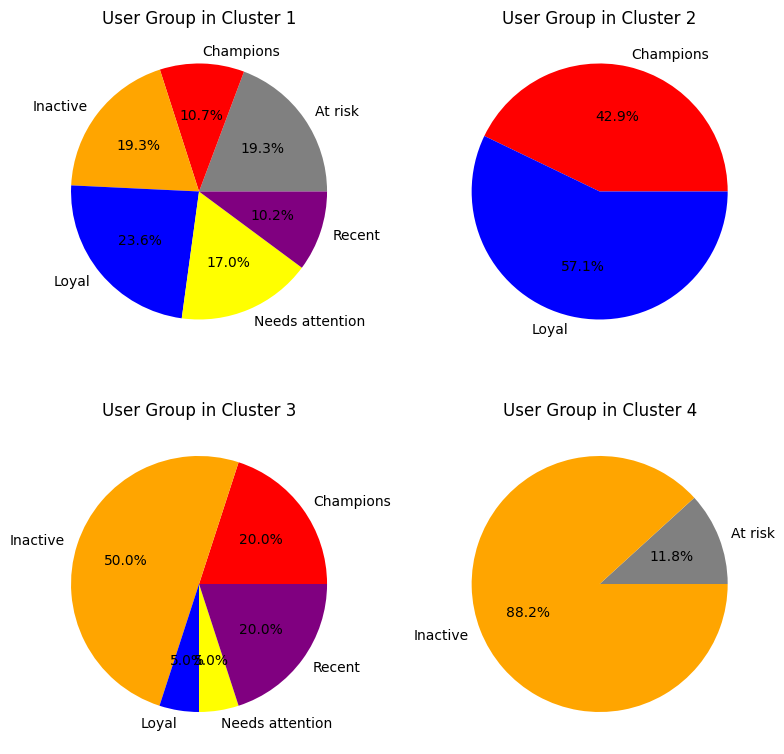

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
ax = ax.flatten()

# Define color mapping for each Customer_Group
color_mapping = {
                'Champions': 'red',
                'Loyal': 'blue',
                'At Risk': 'green',
                'Needs attention': 'yellow',
                'Recent': 'purple',
                'Inactive': 'orange'
                 }

for i, cluster in enumerate(range(1, 5), start=1):
    cluster_data = p2_df[p2_df['Cluster'] == cluster]
    cluster_chart = cluster_data.groupby('Customer_Group')['CustomerID'].count()

    # Map the colors based on Customer_Group
    colors = [color_mapping.get(group, 'gray') for group in cluster_chart.index]

    # Visualize
    cluster_chart.plot(kind='pie', autopct='%1.1f%%', ax=ax[i-1], colors=colors)
    ax[i-1].set_title(f'User Group in Cluster {cluster}')
    ax[i-1].set_ylabel('')

plt.tight_layout()
plt.show()

## **3. Association Rule - Market Basket Analysis**

In [ ]:
# Import libraires

import os
import plotly.express as px
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import operator as op # Trong phân tích giỏ hàng, nó có thể được sử dụng để so sánh và sắp xếp các mục thường xuyên
from mlxtend.frequent_patterns import apriori #  cung cấp các thuật toán để khai thác các mẫu thường xuyên, chẳng hạn như thuật toán Apriori, được sử dụng trong phân tích giỏ hàng để tìm các tập hợp sản phẩm thường xuyên được mua cùng nhau
from mlxtend.frequent_patterns import association_rules # cung cấp các hàm để tạo ra các luật kết hợp từ các tập hợp sản phẩm thường xuyên. Các luật kết hợp thể hiện mối quan hệ giữa các sản phẩm

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Create new dataframe for p3

p3_df = df.copy()

p3_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day      month cohort_month  cohort_index  
0 2010-12-01 2010-12-01      2010-12             0  
1 2010-12-01 2010-12-01      2010-12             0  
2 2010-12-01 2010-12-01      2010-12             0  
3 2010-12-01 2010-12-01      2010-12             0  
4 2010-12-01 2010-12-01      2010-12             0

In [ ]:
# Frequency of sold by Products

Frequency_of_product = p3_df.groupby('Description').size().reset_index(name='frequency').head(40)

fig = px.treemap(Frequency_of_product, path=['Description'], values='frequency')

fig.update_layout(title_text='Frequency of the Top 40 Products Sold',
                  title_x=0.5, title_font=dict(size=18)
                  )

fig.update_traces(textinfo="label+value")
fig.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
baskets = p3_df.groupby(['CustomerID', 'Description'])['Description'].size().unstack().fillna(0).reset_index()

baskets.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Description  CustomerID  MEDIUM CERAMIC TOP STORAGE JAR  \
0               12346.0                             2.0   
1               12347.0                             0.0   
2               12348.0                             0.0   
3               12349.0                             0.0   
4               12350.0                             0.0   

Description  3D DOG PICTURE PLAYING CARDS  3D SHEET OF CAT STICKERS  \
0                                     0.0                       0.0   
1                                     5.0                       1.0   
2                                     0.0                       0.0   
3                                     0.0                       0.0   
4                                     0.0                       0.0   

Description  3D SHEET OF DOG STICKERS  60 TEATIME FAIRY CAKE CASES  \
0                                 0.0                          0.0   
1                                 1.0                          3.0   
2                                 0.0                          2.0   
3                                 0.0                          0.0   
4                                 0.0                          0.0   

Description  72 SWEETHEART FAIRY CAKE CASES  \
0                                       0.0   
1                                       3.0   
2                                       1.0   
3                                       0.0   
4                                       0.0   

Description  AIRLINE BAG VINTAGE JET SET BROWN  \
0                                          0.0   
1                                          6.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

Description  AIRLINE BAG VINTAGE JET SET RED  \
0                                        0.0   
1                                        3.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

Description  AIRLINE BAG VINTAGE JET SET WHITE  ...  \
0                                          0.0  ...   
1                                          3.0  ...   
2                                          0.0  ...   
3                                          0.0  ...   
4                                          0.0  ...   

Description  S/2 BEACH HUT TREASURE CHESTS  PURPLE FRANGIPANI HAIRCLIP  \
0                                      0.0                         0.0   
1                                      0.0                         0.0   
2                                      0.0                         0.0   
3                                      0.0                         0.0   
4                                      0.0                         0.0   

Description  GOLD PRINT PAPER BAG  LILAC FEATHERS CURTAIN  \
0                             0.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   

Description  SET/3 TALL GLASS CANDLE HOLDER PINK  FLOWER SHOP DESIGN MUG  \
0                                            0.0                     0.0   
1                                            0.0                     0.0   
2                                            0.0                     0.0   
3                                            0.0                     0.0   
4                                            0.0                     0.0   

Description  CAPIZ CHANDELIER  BLUE NEW BAROQUE FLOCK CANDLESTICK  \
0                         0.0                                 0.0   
1                         0.0                                 0.0   
2                         0.0                                 0.0   
3                         0.0                   

In [ ]:
# Encoding the items that sold more than 1
def one_hot_encoder(k):
    if k <= 0:
        return 0
    if k >= 1:
        return 1

baskets_final = baskets.iloc[:, 1:baskets.shape[1]].applymap(one_hot_encoder)
baskets_final = baskets_final[baskets_final.columns[:50]]  # Take first 50 products for practice

baskets_final.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-43-920f3c94313d>:8: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Description  MEDIUM CERAMIC TOP STORAGE JAR  3D DOG PICTURE PLAYING CARDS  \
0                                         1                             0   
1                                         0                             1   
2                                         0                             0   
3                                         0                             0   
4                                         0                             0   

Description  3D SHEET OF CAT STICKERS  3D SHEET OF DOG STICKERS  \
0                                   0                         0   
1                                   1                         1   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   

Description  60 TEATIME FAIRY CAKE CASES  72 SWEETHEART FAIRY CAKE CASES  \
0                                      0                               0   
1                                      1                               1   
2                                      1                               1   
3                                      0                               0   
4                                      0                               0   

Description  AIRLINE BAG VINTAGE JET SET BROWN  \
0                                            0   
1                                            1   
2                                            0   
3                                            0   
4                                            0   

Description  AIRLINE BAG VINTAGE JET SET RED  \
0                                          0   
1                                          1   
2                                          0   
3                                          0   
4                                          0   

Description  AIRLINE BAG VINTAGE JET SET WHITE  AIRLINE BAG VINTAGE TOKYO 78  \
0                                            0                             0   
1                                            1                             1   
2                                            0                             0   
3                                            0                             0   
4                                            0                             0   

Description  ...  GREEN REGENCY TEACUP AND SAUCER  HOLIDAY FUN LUDO  \
0            ...                                0                 0   
1            ...                                1                 1   
2            ...                                0                 0   
3            ...                                0                 0   
4            ...                                0                 0   

Description  ICE CREAM SUNDAE LIP GLOSS  LARGE HEART MEASURING SPOONS  \
0                                     0                             0   
1                                     1                             1   
2                                     1                             0   
3                                     0                             1   
4                                     0                             0   

Description  MADRAS NOTEBOOK MEDIUM  MINI LADLE LOVE HEART RED   \
0                                 0                           0   
1                                 1                           1   
2                                 0                           0   
3                                 0                           0   
4                                 0                           0   

Description  MINI LIGHTS WOODLAND MUSHROOMS  MINI PAINT SET VINTAGE   \
0                                         0                        0   
1                                         1                        1   
2                                         0                        0   
3                                         0      

In [ ]:
# Finding the most frequent items sold together - Calculate SUPPORT

frequent_itemsets = apriori(baskets_final, min_support=0.025, use_colnames=True).sort_values(by='support')
frequent_itemsets['items_count'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets.head(25)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



support                                           itemsets  items_count
33  0.026075  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...            3
21  0.026075                     (MINI PLAYING CARDS SPACEBOY )            1
13  0.026304                 (FOOD CONTAINER SET 3 LOVE HEART )            1
36  0.026532  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...            3
9   0.026990                   (CHRISTMAS METAL TAGS ASSORTED )            1
29  0.027905  (ALARM CLOCK BAKELIKE ORANGE, ALARM CLOCK BAKE...            2
24  0.028362  (ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELI...            2
32  0.029506  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...            3
34  0.030421  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...            3
16  0.031107                                 (HOLIDAY FUN LUDO)            1
0   0.031565                   (MEDIUM CERAMIC TOP STORAGE JAR)            1
23  0.031793  (ALARM CLOCK BAKELIKE CHOCOLATE, ALARM CLOCK B...            2
26  0.032479  (ALARM CLOCK BAKELIKE ORANGE, ALARM CLOCK BAKE...            2
19  0.032708                   (MINI LIGHTS WOODLAND MUSHROOMS)            1
3   0.033166                     (AIRLINE BAG VINTAGE TOKYO 78)            1
14  0.033394                       (FOUR HOOK  WHITE LOVEBIRDS)            1
18  0.033852                     (LARGE HEART MEASURING SPOONS)            1
10  0.034081                     (CLASSIC CHROME BICYCLE BELL )            1
25  0.034081  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...            2
12  0.034309                (COLOUR GLASS. STAR T-LIGHT HOLDER)            1
30  0.035682  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...            2
11  0.038655              (CLEAR DRAWER KNOB ACRYLIC EDWARDIAN)            1
4   0.039799                   (ALARM CLOCK BAKELIKE CHOCOLATE)            1
35  0.040942  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...            3
6   0.041400                      (ALARM CLOCK BAKELIKE ORANGE)            1

In [ ]:
# Calculate Lift and Confidence
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1, num_itemsets=8).sort_values(['lift', 'confidence','support'], ascending=[False, False, False])

# rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].round(3)
rules = rules.round(3)

rules.head(10)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



antecedents  \
5                    (ALARM CLOCK BAKELIKE CHOCOLATE)   
0   (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...   
10                      (ALARM CLOCK BAKELIKE ORANGE)   
7   (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...   
20                   (ALARM CLOCK BAKELIKE CHOCOLATE)   
17  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...   
26                      (ALARM CLOCK BAKELIKE ORANGE)   
23  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...   
16  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...   
21                       (ALARM CLOCK BAKELIKE GREEN)   

                                          consequents  antecedent support  \
5   (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...               0.040   
0                    (ALARM CLOCK BAKELIKE CHOCOLATE)               0.052   
10  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...               0.041   
7                       (ALARM CLOCK BAKELIKE ORANGE)               0.052   
20  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...               0.040   
17                   (ALARM CLOCK BAKELIKE CHOCOLATE)               0.061   
26  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...               0.041   
23                      (ALARM CLOCK BAKELIKE ORANGE)               0.061   
16                       (ALARM CLOCK BAKELIKE GREEN)               0.034   
21  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...               0.074   

    consequent support  support  confidence    lift  representativity  \
5                0.052    0.026       0.655  12.619               1.0   
0                0.040    0.026       0.502  12.619               1.0   
10               0.052    0.027       0.641  12.343               1.0   
7                0.041    0.027       0.511  12.343               1.0   
20               0.061    0.030       0.741  12.231               1.0   
17               0.040    0.030       0.487  12.231               1.0   
26               0.061    0.030       0.735  12.123               1.0   
23               0.041    0.030       0.502  12.123               1.0   
16               0.074    0.030       0.866  11.719               1.0   
21               0.034    0.030       0.399  11.719               1.0   

    leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski  
5      0.024       2.749          0.959    0.397      0.636       0.579  
0      0.024       1.929          0.971    0.397      0.482       0.579  
10     0.024       2.640          0.959    0.397      0.621       0.576  
7      0.024       1.960          0.969    0.397      0.490       0.576  
20     0.027       3.632          0.956    0.416      0.725       0.614  
17     0.027       1.871          0.977    0.416      0.466       0.614  
26     0.028       3.542          0.957    0.425      0.718       0.618  
23     0.028       1.924          0.977    0.425      0.480       0.618  
16     0.027       6.900          0.947    0.376      0.855       0.633  
21     0.027       1.608          0.988    0.376      0.378       0.633

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Convert frozenset to strings for visualization
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Heatmap
fig = px.scatter(rules.head(1000), x='support', y='confidence', size='lift',
                 color='lift', hover_data=['antecedents', 'consequents'],
                 title='Bubble Chart of Association Rules',
                 size_max=10)

fig.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## **4. Cohort Analysis**

**Strategic Approach:** Aiming to understanding the characteristics of **Retention** and **Spending**

### **A. Retention**

In [ ]:
df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0     71053                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

         day      month cohort_month  cohort_index  
0 2010-12-01 2010-12-01      2010-12             0  
1 2010-12-01 2010-12-01      2010-12             0  
2 2010-12-01 2010-12-01      2010-12             0  
3 2010-12-01 2010-12-01      2010-12             0  
4 2010-12-01 2010-12-01      2010-12             0

In [ ]:
cohort = df

# Create month columns for co-hort
cohort['month'] = cohort['day'].dt.strftime('%Y-%m')

# Select co-hort month - First month purchase
cohort['cohort_month'] = cohort.groupby('CustomerID')['month'].transform('min')

# Convert to datetime format
cohort['cohort_month'] = pd.to_datetime(cohort['cohort_month']).dt.to_period('M')
cohort['month'] = pd.to_datetime(cohort['month'], format='%Y-%m')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Create Cohort index
cohort['cohort_index'] = (cohort['month'].dt.year - cohort['cohort_month'].dt.year) * 12 \
                          + (cohort['month'].dt.month - cohort['cohort_month'].dt.month) # Convert year, then sum with month

cohort.tail()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



InvoiceNo StockCode                      Description  Quantity  \
541904   581587.0     22613      PACK OF 20 SPACEBOY NAPKINS      12.0   
541905   581587.0     22899     CHILDREN'S APRON DOLLY GIRL        6.0   
541906   581587.0     23254    CHILDRENS CUTLERY DOLLY GIRL        4.0   
541907   581587.0     23255  CHILDRENS CUTLERY CIRCUS PARADE       4.0   
541908   581587.0     22138    BAKING SET 9 PIECE RETROSPOT        3.0   

               InvoiceDate  UnitPrice  CustomerID Country  revenue        day  \
541904 2011-12-09 12:50:00       0.85     12680.0  France    10.20 2011-12-09   
541905 2011-12-09 12:50:00       2.10     12680.0  France    12.60 2011-12-09   
541906 2011-12-09 12:50:00       4.15     12680.0  France    16.60 2011-12-09   
541907 2011-12-09 12:50:00       4.15     12680.0  France    16.60 2011-12-09   
541908 2011-12-09 12:50:00       4.95     12680.0  France    14.85 2011-12-09   

            month cohort_month  cohort_index  
541904 2011-12-01      2011-08             4  
541905 2011-12-01      2011-08             4  
541906 2011-12-01      2011-08             4  
541907 2011-12-01      2011-08             4  
541908 2011-12-01      2011-08             4

In [ ]:
# Create cohort - Number of Customers
retention_pv = df.groupby(['cohort_month','cohort_index'])['CustomerID'] \
              .nunique() \
              .reset_index()

# Switch to standard of cohort format
cohort_counted = retention_pv.pivot_table(index='cohort_month', columns='cohort_index', values='CustomerID')

cohort_counted

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



cohort_index     0      1      2      3      4      5      6      7      8   \
cohort_month                                                                  
2010-12       948.0  362.0  317.0  367.0  341.0  376.0  360.0  336.0  336.0   
2011-01       421.0  101.0  119.0  102.0  138.0  126.0  110.0  108.0  131.0   
2011-02       380.0   94.0   73.0  106.0  102.0   94.0   97.0  107.0   98.0   
2011-03       440.0   84.0  112.0   96.0  102.0   78.0  116.0  105.0  127.0   
2011-04       299.0   68.0   66.0   63.0   62.0   71.0   69.0   78.0   25.0   
2011-05       279.0   66.0   48.0   48.0   60.0   68.0   74.0   29.0    NaN   
2011-06       235.0   49.0   44.0   64.0   58.0   79.0   24.0    NaN    NaN   
2011-07       191.0   40.0   39.0   44.0   52.0   22.0    NaN    NaN    NaN   
2011-08       167.0   42.0   42.0   42.0   23.0    NaN    NaN    NaN    NaN   
2011-09       298.0   89.0   97.0   36.0    NaN    NaN    NaN    NaN    NaN   
2011-10       352.0   93.0   46.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11       321.0   43.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12        41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cohort_index     9      10     11     12  
cohort_month                              
2010-12       374.0  354.0  474.0  260.0  
2011-01       146.0  155.0   63.0    NaN  
2011-02       119.0   35.0    NaN    NaN  
2011-03        39.0    NaN    NaN    NaN  
2011-04         NaN    NaN    NaN    NaN  
2011-05         NaN    NaN    NaN    NaN  
2011-06         NaN    NaN    NaN    NaN  
2011-07         NaN    NaN    NaN    NaN  
2011-08         NaN    NaN    NaN    NaN  
2011-09         NaN    NaN    NaN    NaN  
2011-10         NaN    NaN    NaN    NaN  
2011-11         NaN    NaN    NaN    NaN  
2011-12         NaN    NaN    NaN    NaN

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



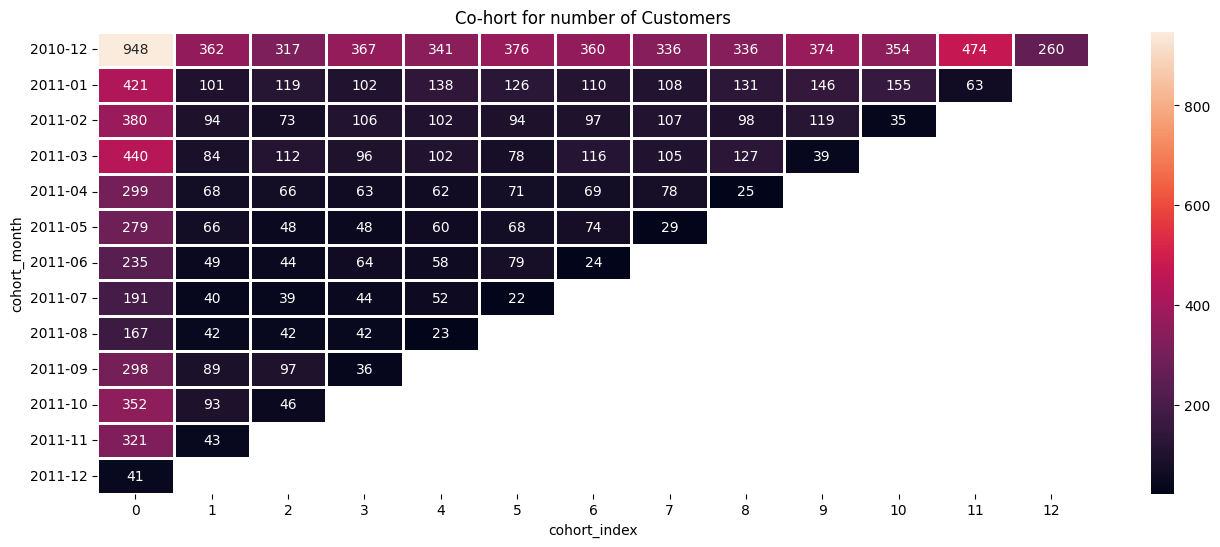

In [ ]:
# Visualize
plt.figure(figsize=(16,6))

#plt.title('Cohort analysis-Rates')
sns.heatmap(data=cohort_counted, fmt=".0f", annot=True,linewidth=1)

plt.title("Co-hort for number of Customers")
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



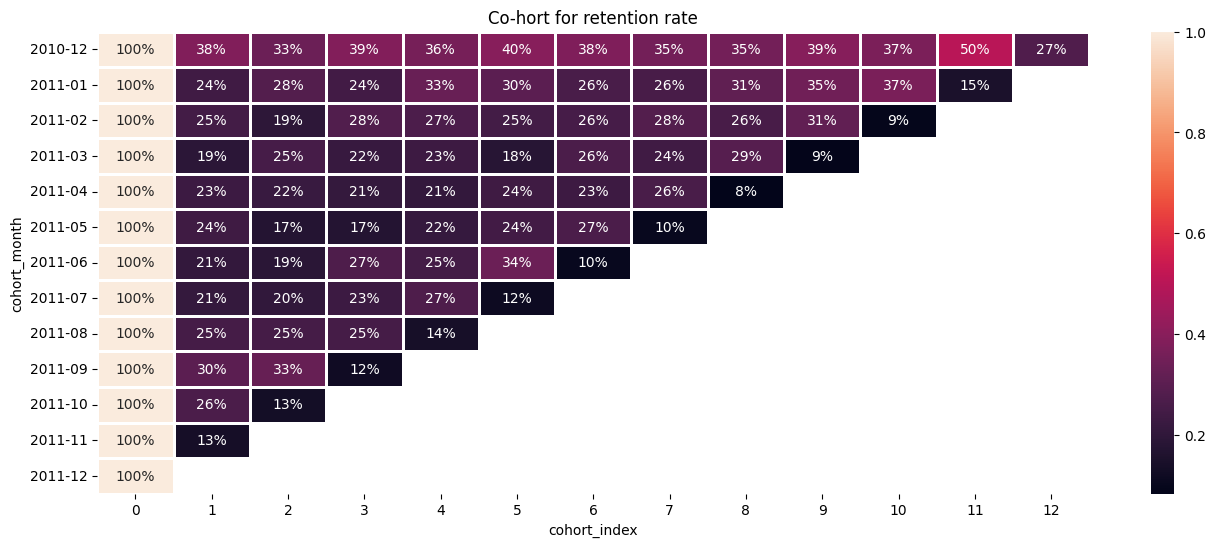

In [ ]:
# Create cohort - Retention
cohort_totals = cohort_counted.iloc[:,0]
retention_rates = cohort_counted.divide(cohort_totals, axis=0) # Chia cho total từng hàng

# Output
retention_rates.round(3)*100

# Visualize !!!!

plt.figure(figsize=(16,6))
#plt.title('Cohort analysis-Rates')
sns.heatmap(data=retention_rates, annot=True, fmt='.0%',linewidth=1)

plt.title("Co-hort for retention rate")
plt.show()

### **B. Spending**

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



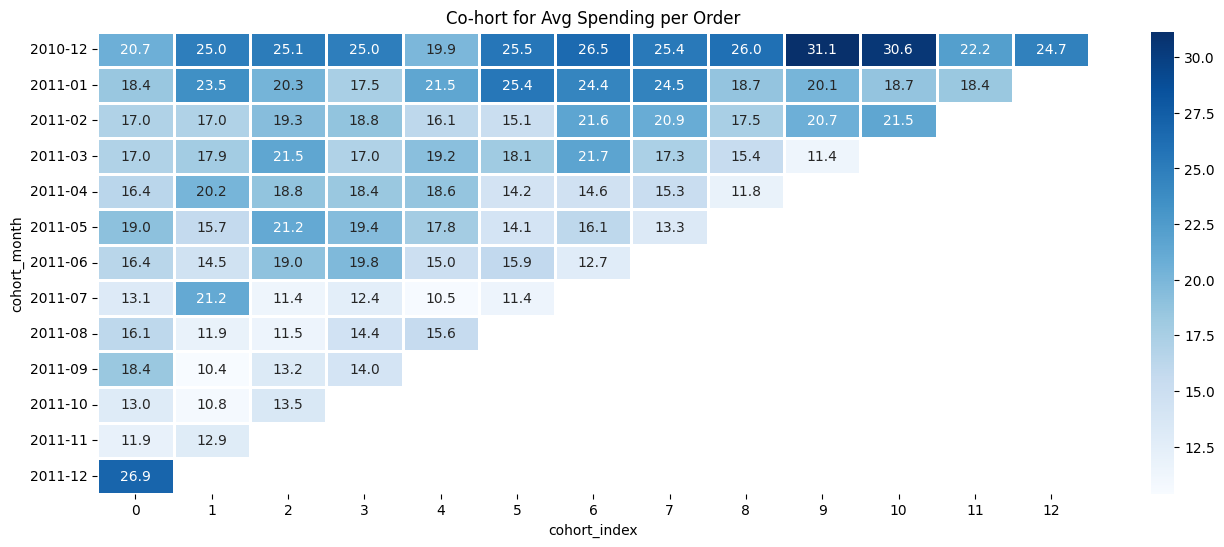

In [ ]:
# Create cohort - Avg Spending (spending per order)
spending_pv = df.groupby(['cohort_month','cohort_index'])['revenue'] \
              .mean() \
              .reset_index()

# Switch to standard of cohort format
cohort_spending = spending_pv.pivot_table(index='cohort_month', columns='cohort_index', values='revenue')

# Visualize
plt.figure(figsize=(16,6))

#plt.title('Cohort analysis-Rates')
sns.heatmap(data=cohort_spending, fmt=".1f", annot=True, cmap = "Blues", linewidth=1)

plt.title("Co-hort for Avg Spending per Order")
plt.show()

**Conclusion**

* **Product lifetime (vertically)** - comparing different cohorts at the same stage in their lifecycle.

=> The key problem of business is here, as new customers immediately churned ~3/4 after joining only 1 month

=> A sharp drop-off in the second month (indexed as 1) already, on average around 80% of customers do not make any purchase in the second month.

* **User lifetime (horizontally)** - long term relationship with customers in any cohort. How long people are coming back and how valuable that cohort is. (campaign effects, limitations etc.)

=> Observing, it has no clear alert signal for this, the key focus will be customer retention to improve product lifetime

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

